In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt

from statsforecast import StatsForecast
from statsforecast.models import AutoETS

from hierarchicalforecast.utils import aggregate
from hierarchicalforecast.methods import BottomUp, MinTrace
from hierarchicalforecast.core import HierarchicalReconciliation

from sklearn.metrics import mean_squared_error, mean_absolute_error

/home/grc/arep/time_series/lib/python3.10/site-packages/statsforecast/core.py:25: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
def get_metrics(
    test_df,
    forecast_df,
    index_label="Total"
):
    t = [
        ("rmse", "ets"),
        ("rmse", "bu"),
        ("rmse", "ols"),
        ("rmse", "mint"),
        ("mae", "ets"),
        ("mae", "bu"),
        ("mae", "ols"),
        ("mae", "mint"),
    ]

    m = [
        np.sqrt(mean_squared_error(test_df["y"], forecast_df["ets"])),
        np.sqrt(mean_squared_error(test_df["y"], forecast_df["bu"])),
        np.sqrt(mean_squared_error(test_df["y"], forecast_df["ols"])),
        np.sqrt(mean_squared_error(test_df["y"], forecast_df["mint"])),
        mean_absolute_error(test_df["y"], forecast_df["ets"]),
        mean_absolute_error(test_df["y"], forecast_df["bu"]),
        mean_absolute_error(test_df["y"], forecast_df["ols"]),
        mean_absolute_error(test_df["y"], forecast_df["mint"])
    ]

    j = pd.DataFrame(
        m,
        index=pd.MultiIndex.from_tuples(t, names=["metric", "model"])
    ).rename(columns={0: index_label}).T

    return j

### 1.0. Forecasting hierarchical and grouped time series

Muitas vezes as séries temporais são desagregadas naturalmente, por exemplo vendas, podem existir vendas por produtos, por região, por tudo oque você conseguir medir e quebrar o fato que é a venda. Isso é bem simples de entender olhando a modelagem dimensional ou voltando aos olhos em bancos de dados onde cada tabela pode ser ligada com uma outra e assim sucessivamente, visando o fato (venda) e todas as quebras que existem, posso separar a série temporal em vários grupos.

![image](https://docs.oracle.com/cd/E41507_01/epm91pbr3/eng/epm/penw/img/i-4642ab0fn-7924.png)

Fonte: Docs Oracle, modelagem dimensional de um Data Warehouse.

Outro exemplo, o número total de bicicletas vendidas por um fabricante de bicicletas pode ser desagregado por tipo de produto, como bicicletas de estrada, bicicletas de montanha e híbridas. Cada um deles pode ser desagregado em categorias mais refinadas. Por exemplo, as bicicletas híbridas podem ser divididas em bicicletas urbanas, de deslocamento diário, de conforto e de trekking; e assim por diante.

Todas essas categorias estão aninhadas (nested) nas categorias de grupos maiores, portanto a série segue uma estrutura de aninhação hierárquica.

Estruturas alternativas de agregação surgem quando atributos de interesse são cruzados (crossed) em vez de aninhados. Por exemplo, o fabricante de bicicletas pode estar interessado em atributos como tamanho do quadro, sexo, faixa de preço, etc. Tais atributos não são desagregados naturalmente de uma maneira hierárquica única, pois os atributos não estão aninhados. Referimo-nos à série temporal resultante de atributos cruzados como “série temporal agrupada”.

Estruturas mais complexas surgem quando atributos de interesse são aninhados e cruzados. Por exemplo, seria natural que o fabricante de bicicletas estivesse interessado nas vendas por tipo de produto e também por divisão geográfica. Em seguida, os agrupamentos de produtos e a hierarquia geográfica são misturados gerando uma estrutura complexa.

É natural realizar previsões em séries agregadas e em séries desagregadas e também somar as previsões da mesma forma que agrupamos os dados para agregar e desagregar as séries temporáis.

O desafio agora é gerar previsões **coerentes** em toda a estrutura hierárquica da série.

#### 1.1. Hierarchical time series

No livro é detalhado essa estrutura levando em conta essa visão:

No topo é a série mais agregada possível, e o total é desagregado em mais duas séries (A, B) e cada uma delas é sub dividida novamente em mais e mais níveis hierárquicos, o número total de series na hierarquia é $n = 1 + 2 + 5 = 8$ e o número de séries no mais baixo nível é $m= 8$.

Já para cada tempo $t$, as observações no mais baixo nível da hierarquia é a soma das observações a cada nível agregado acima.

$y_t = y_{AA,t} + y_{AB,t} + y_{AC,t} + y_{BA,t} + y_{BB,t}$, consequentemente $y_t = y_{A,t} + y_{B,t}$

![image](https://otexts.com/fpp3/figs/hts.png)

O exemplo que o livro começa a abordar sobre o assunto é relacionado aos dados de turismo na Austrália, onde a Austrália é dividida em sete estados (State) e cada estado pode ter várias regioes (Region).

![image](https://otexts.com/fpp3/fpp_files/figure-html/ausmap-1.png)

In [32]:
df = pd.read_csv("../data/tourism.csv", index_col=[0])
df['Quarter'] = df.Quarter.apply(lambda x: x.replace(' ', '-'))
df['Quarter'] = pd.PeriodIndex(df.Quarter, freq='Q').to_timestamp()

df.head()

Quarter    Region            State   Purpose       Trips
1 1998-01-01  Adelaide  South Australia  Business  135.077690
2 1998-04-01  Adelaide  South Australia  Business  109.987316
3 1998-07-01  Adelaide  South Australia  Business  166.034687
4 1998-10-01  Adelaide  South Australia  Business  127.160464
5 1999-01-01  Adelaide  South Australia  Business  137.448533

In [8]:
display(df.State.value_counts())

display(df.Region.value_counts())

State
Victoria              6720
New South Wales       4160
South Australia       3840
Queensland            3840
Northern Territory    2240
Western Australia     1600
Tasmania              1600
ACT                    320
Name: count, dtype: int64

Region
Adelaide                  320
Mallee                    320
North West                320
North Coast NSW           320
New England North West    320
                         ... 
East Coast                320
Darwin                    320
Darling Downs             320
Clare Valley              320
Yorke Peninsula           320
Name: count, Length: 76, dtype: int64

Para ficar mais fácil a escrita das regiões foi feito apenas um rename das regioes.

In [34]:
state_dict = {
    "New South Wales": "NSW",
    "Northern Territory": "NT",
    "Queensland": "QLD",
    "South Australia": "SA",
    "Tasmania": "TAS",
    "Victoria": "VIC",
    "ACT": "ACT",
    "Western Australia": "WA"
}

df.State = df.State.map(state_dict)

No python iria ser meio complicado gerar as séries todas agregadas bunitinhas em apenas um DataFrame igual esta no livro, então separei em 2 para ter os dois nívels de agregação, por região e estado e apenas por estado.

In [36]:
df_state_region = df[["Quarter", "Region", "State", "Trips"]].groupby(["Quarter", "Region", "State"]).sum().reset_index()

df_state = df[["Quarter", "State", "Trips"]].groupby(["Quarter", "State"]).sum().reset_index()

Podemos ver vários padrões em todas as séris de cada uma das regiões, todas as regiões são diferentes, com excessão de NT e TAS, entretanto o mesmo modelo de previsão pode não funcionar para as outras regiões, ou seja, cadaq região é uma série independente nesse sentido.

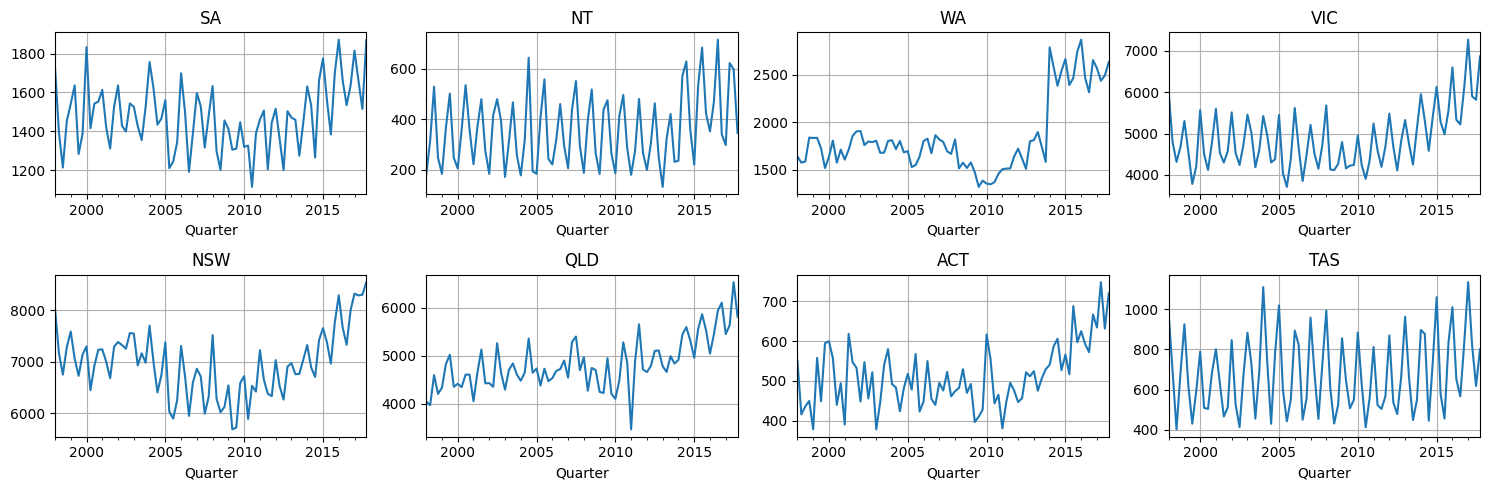

In [64]:
fig, ax = plt.subplots(2, 4, figsize=(15, 5))
ax = ax.flatten()

for axi, state in zip(ax, df.State.unique()):
    df_state[df_state["State"] == state].plot(x="Quarter", ax=axi, legend=None)
    axi.set_title(state)
    axi.grid(2)

plt.tight_layout()

Podemos observar até padrões diferentes em cada uma das séries.

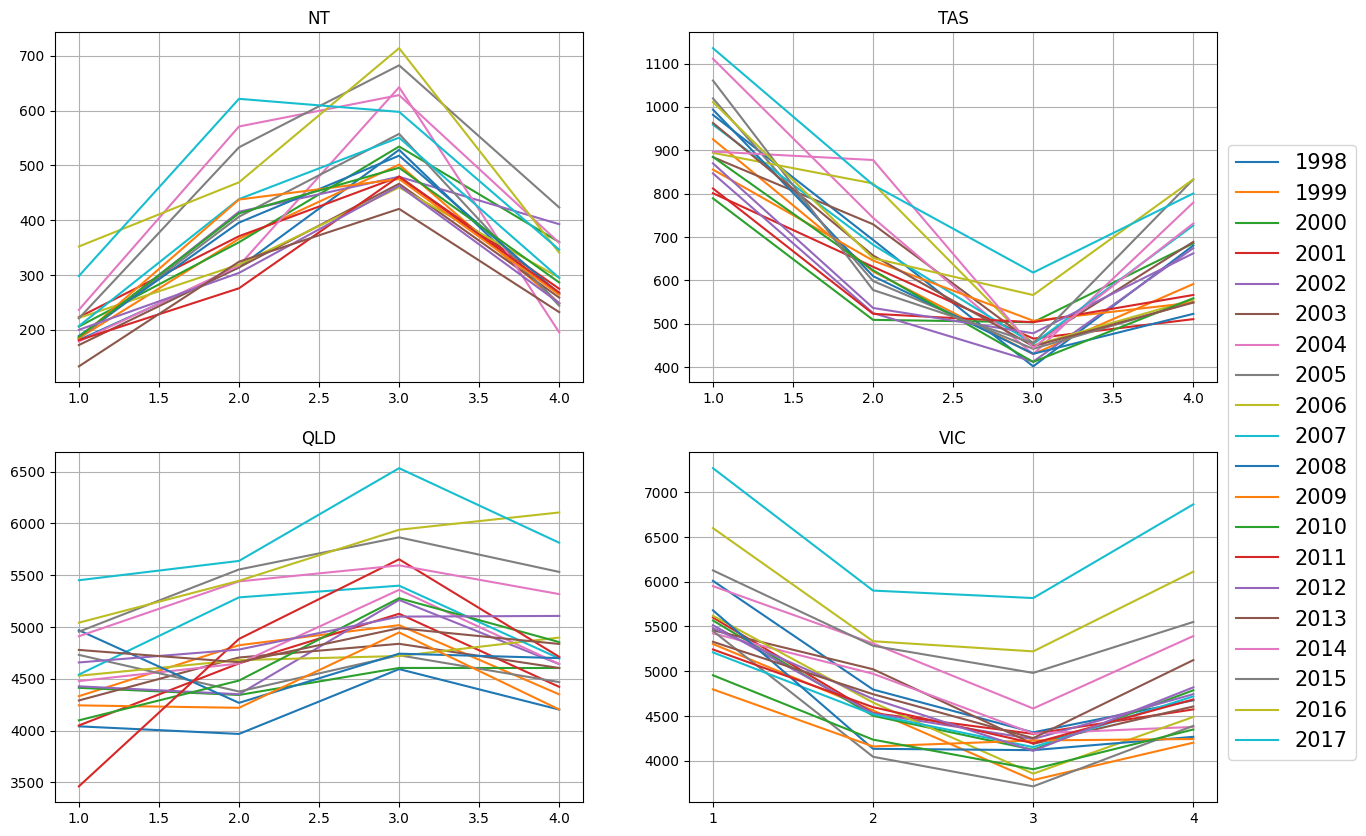

In [91]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
ax = ax.flatten()

df_state['quarter_index'] = df_state["Quarter"].dt.quarter
df_state['year'] = df_state['Quarter'].dt.year

for state, axi in zip(["NT", "TAS", "QLD", "VIC"], ax):
    dfbs_plot = df_state[df_state.State == state].reset_index(drop=True)
    dfbs_plot = dfbs_plot[['quarter_index', 'year', 'Trips']].groupby(['year', 'quarter_index']).sum('Trips').reset_index()
    dfbs_plot = dfbs_plot.sort_values(by=['year', 'quarter_index'])

    ax.set_xticks(
        ticks=range(1, len(dfbs_plot.quarter_index.unique()) + 1), 
        labels=[1, 2, 3, 4]
    )

    for variable in dfbs_plot['year'].unique():
        aux = dfbs_plot[dfbs_plot['year'] == variable]
        axi.plot(aux['quarter_index'], aux['Trips'], label=variable)

    axi.set_title(state)
    axi.grid(2)

axi.legend(loc='center left', bbox_to_anchor=(1, 1), fontsize=15);

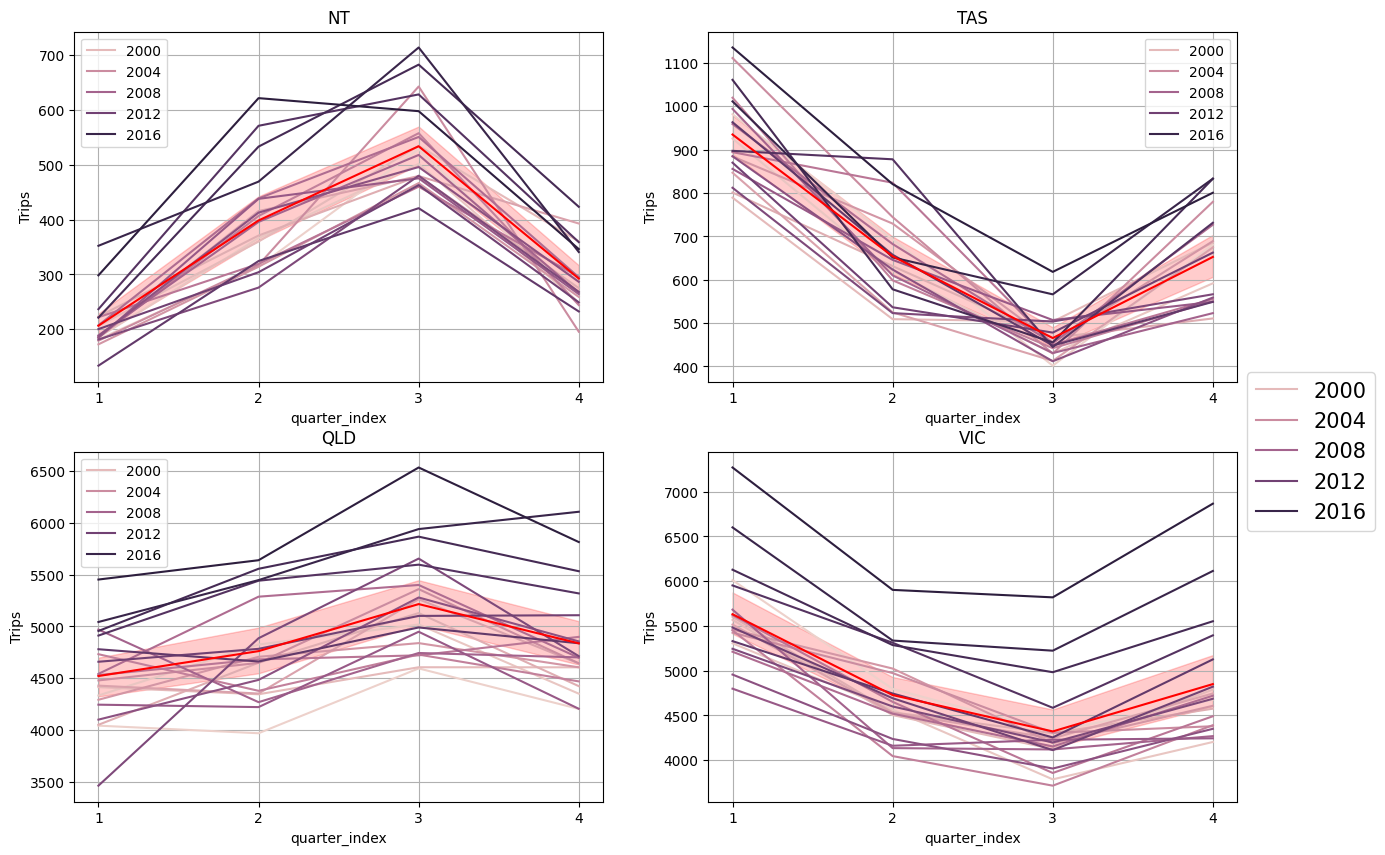

In [138]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
ax = ax.flatten()

df_state['quarter_index'] = df_state["Quarter"].dt.quarter
df_state['year'] = df_state['Quarter'].dt.year

for state, axi in zip(["NT", "TAS", "QLD", "VIC"], ax):
    dfbs_plot = df_state[df_state.State == state].reset_index(drop=True)
    dfbs_plot = dfbs_plot[['quarter_index', 'year', 'Trips']].groupby(['year', 'quarter_index']).sum('Trips').reset_index()
    dfbs_plot = dfbs_plot.sort_values(by=['year', 'quarter_index'])

    axi.set_xticks(
        ticks=range(1, len(dfbs_plot.quarter_index.unique()) + 1), 
        labels=["1", "2", "3", "4"]
    )

    sns.lineplot(dfbs_plot, x="quarter_index", y="Trips", hue="year", ax=axi)
    sns.lineplot(dfbs_plot, x="quarter_index", y="Trips", ax=axi, color="red")

    axi.set_title(state)
    axi.grid(2)

axi.legend(loc='center left', bbox_to_anchor=(1, 1), fontsize=15);

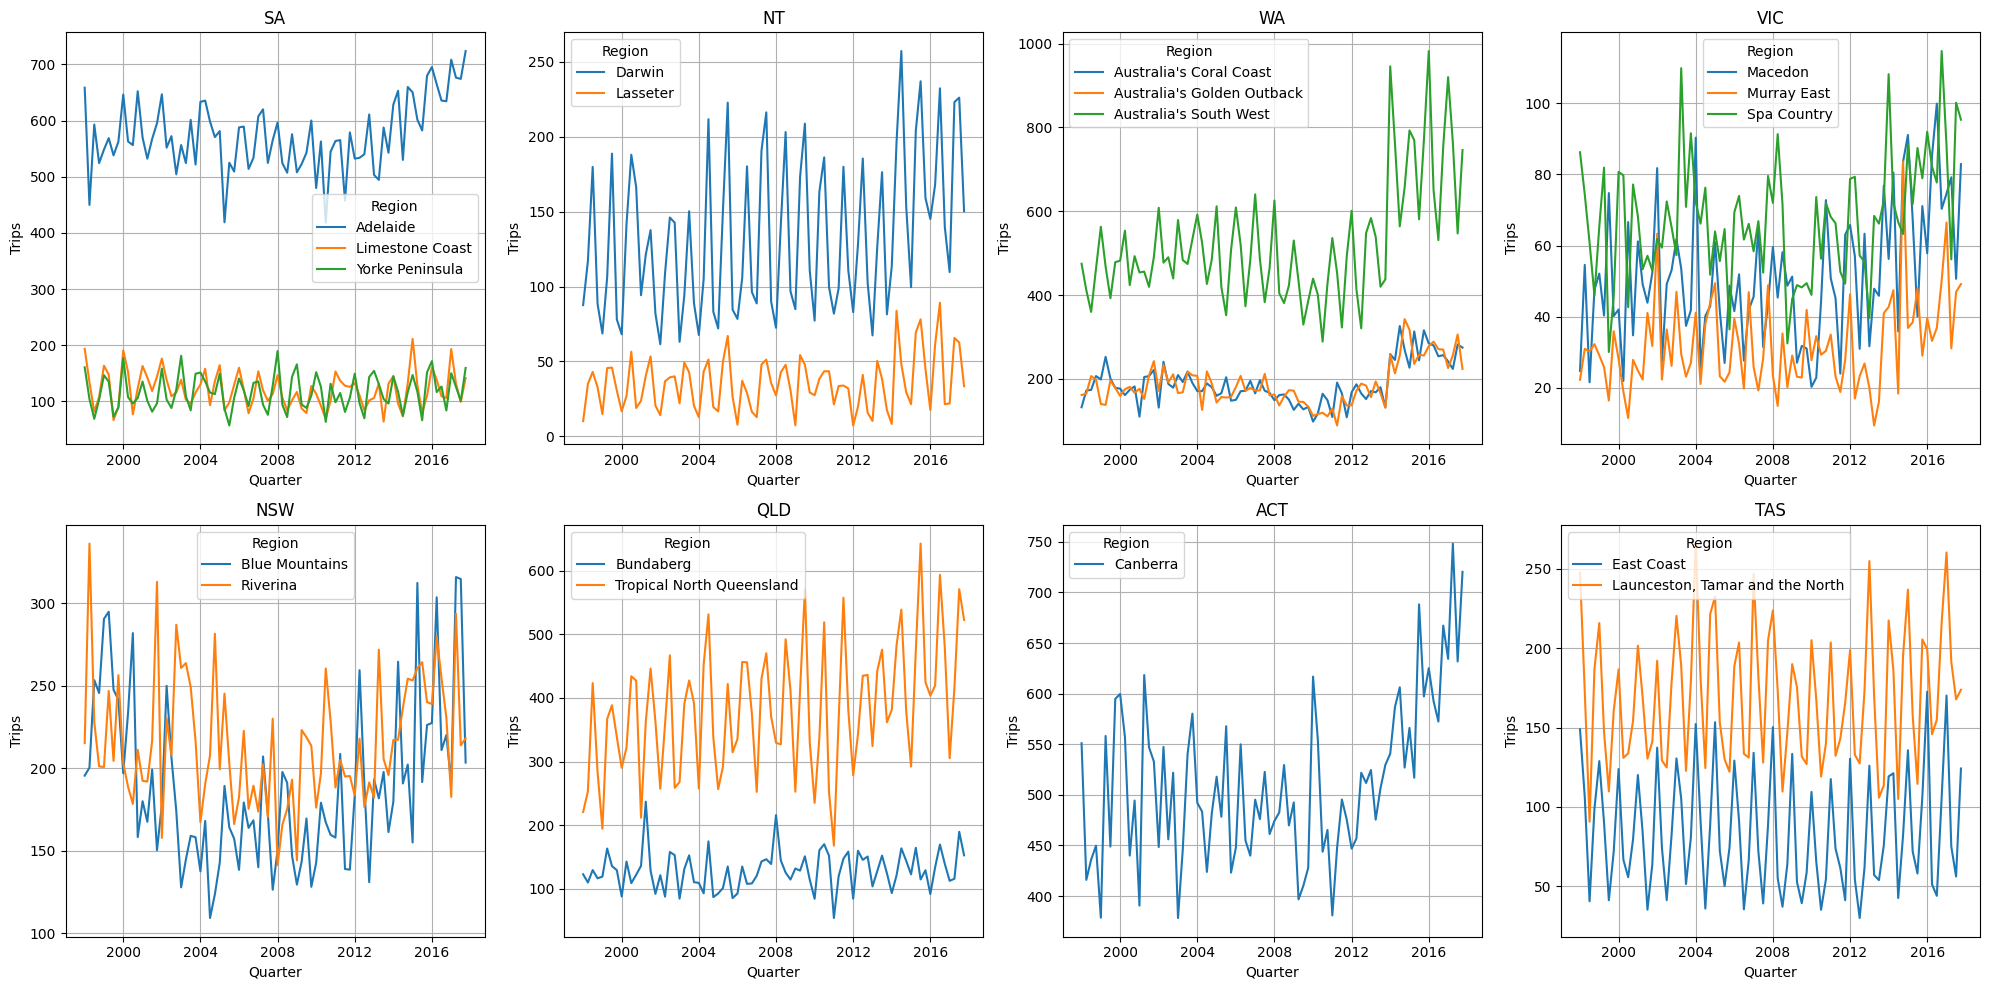

In [118]:
fig, ax = plt.subplots(2, 4, figsize=(20, 10))
ax = ax.flatten()

for axi, state in zip(ax, df.State.unique()):
    dfp = df_state_region[df_state_region.State == state].reset_index(drop=True)
    region_sample = dfp.Region.sample(3).values
    dfp = dfp[dfp.Region.isin(region_sample)]
    sns.lineplot(dfp, x="Quarter", y="Trips", hue="Region", ax=axi)
    axi.set_title(state)
    axi.grid(2)

plt.tight_layout()

#### 1.2. Grouped time series

Nesse sentido agora, essa nova forma de observar as hierarquias é visando uma estrutura de dados que não é agregada naturalmente.

![image](https://otexts.com/fpp3/fpp_files/figure-html/GroupTree-1.png)

No topo o total, novamente representado também por $y_t$, entretanto agora a mesma série pode ser fruto de várias agregações de diferentes formas.

As séries temporais agrupadas podem por vezes ser pensadas como séries temporais hierárquicas que não impõem uma estrutura hierárquica única, no sentido de que a ordem pela qual as séries podem ser agrupadas não é única.

O exemplo a ser considerado agora é de dados de prisões na Austrália, os dados são também em quarters de 2005 a 2016 e existem alguns grupos, como o Estado, Genero, Status Legal (se o prisioneiro ous prisioneiros já foi ou não sentenciado) que serão analisados.

In [142]:
df = pd.read_csv("https://OTexts.com/fpp3/extrafiles/prison_population.csv")

df.Date = pd.to_datetime(df.Date)

df = df[["Date", "State", "Gender", "Legal", "Count"]]

/tmp/ipykernel_5009/2992722294.py:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax0 = plt.subplot2grid((2, 3), (0, 0), colspan=3)


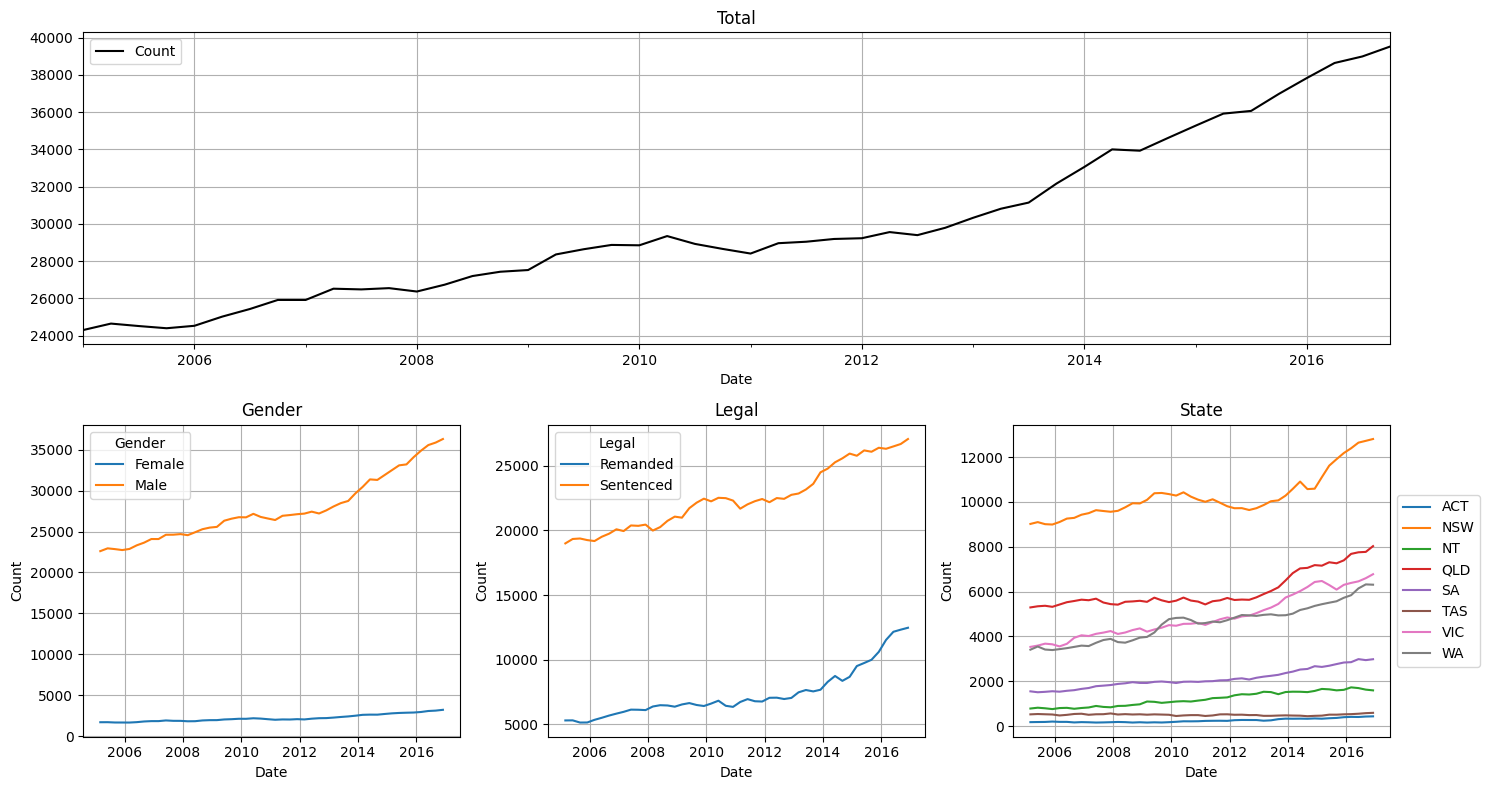

In [176]:
_, _, = plt.subplots(figsize=(15,8))
ax0 = plt.subplot2grid((2, 3), (0, 0), colspan=3)
ax1 = plt.subplot2grid((2, 3), (1, 0))
ax2 = plt.subplot2grid((2, 3), (1, 1))
ax3 = plt.subplot2grid((2, 3), (1, 2))

df[["Date", "Count"]].groupby("Date").sum().plot(color="k", ax=ax0)
sns.lineplot(
    df[["Date", "Gender", "Count"]].groupby(["Date", "Gender"]).sum().reset_index(),
    x="Date", y="Count", hue="Gender", ax=ax1
)
sns.lineplot(
    df[["Date", "Legal", "Count"]].groupby(["Date", "Legal"]).sum().reset_index(),
    x="Date", y="Count", hue="Legal", ax=ax2
)
sns.lineplot(
    df[["Date", "State", "Count"]].groupby(["Date", "State"]).sum().reset_index(),
    x="Date", y="Count", hue="State", ax=ax3
)

ax3.legend(loc='center left', bbox_to_anchor=(1, 0.5));

for axi, label in zip([ax0, ax1, ax2, ax3], ["Total", "Gender", "Legal", "State"]): axi.grid(2); axi.set_title(label)

plt.tight_layout()

#### 1.3. Mixed Hierarchical and Grouped time series

Geralmente podemos trabalhar com os dois casos no mesmo conjunto de dados.

Por exemplo, os dados do turismo australiano no arquivo `tourism` também podem ser desagregados pelos quatro propósitos da viagem: férias, negócios, visita a amigos e familiares e outros. Esta variável de agrupamento não se aninha em nenhuma das variáveis geográficas. Na verdade, poderíamos considerar viagens noturnas divididas por finalidade de viagem para toda a Austrália, e para cada estado, e para cada região. Descrevemos tal estrutura como uma hierarquia geográfica “aninhada” “cruzada” com o propósito de viajar.

In [178]:
df = pd.read_csv("../data/tourism.csv", index_col=[0])
df['Quarter'] = df.Quarter.apply(lambda x: x.replace(' ', '-'))
df['Quarter'] = pd.PeriodIndex(df.Quarter, freq='Q').to_timestamp()

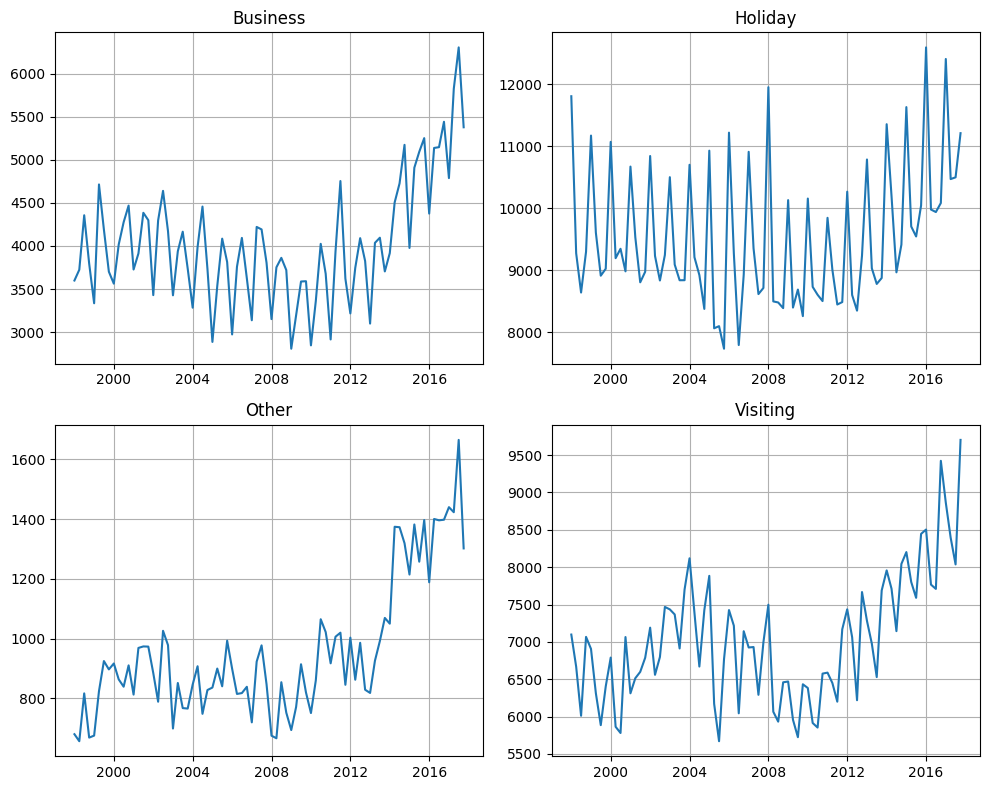

In [191]:
fig, ax = plt.subplots(2, 2, figsize=(10, 8))
ax = ax.flatten()

dfp = df[["Quarter", "Purpose", "Trips"]].groupby(["Quarter", "Purpose"]).sum().reset_index()

for axi, purpose in zip(ax, dfp.Purpose.unique()):
    dfpp = dfp[dfp.Purpose == purpose].reset_index()

    axi.plot(dfpp["Quarter"], dfpp["Trips"])

    axi.set_title(purpose)
    axi.grid(2)

plt.tight_layout()

In [196]:
dfp = df[["Quarter", "State", "Purpose", "Trips"]].groupby(["Quarter", "State", "Purpose"]).sum().reset_index()

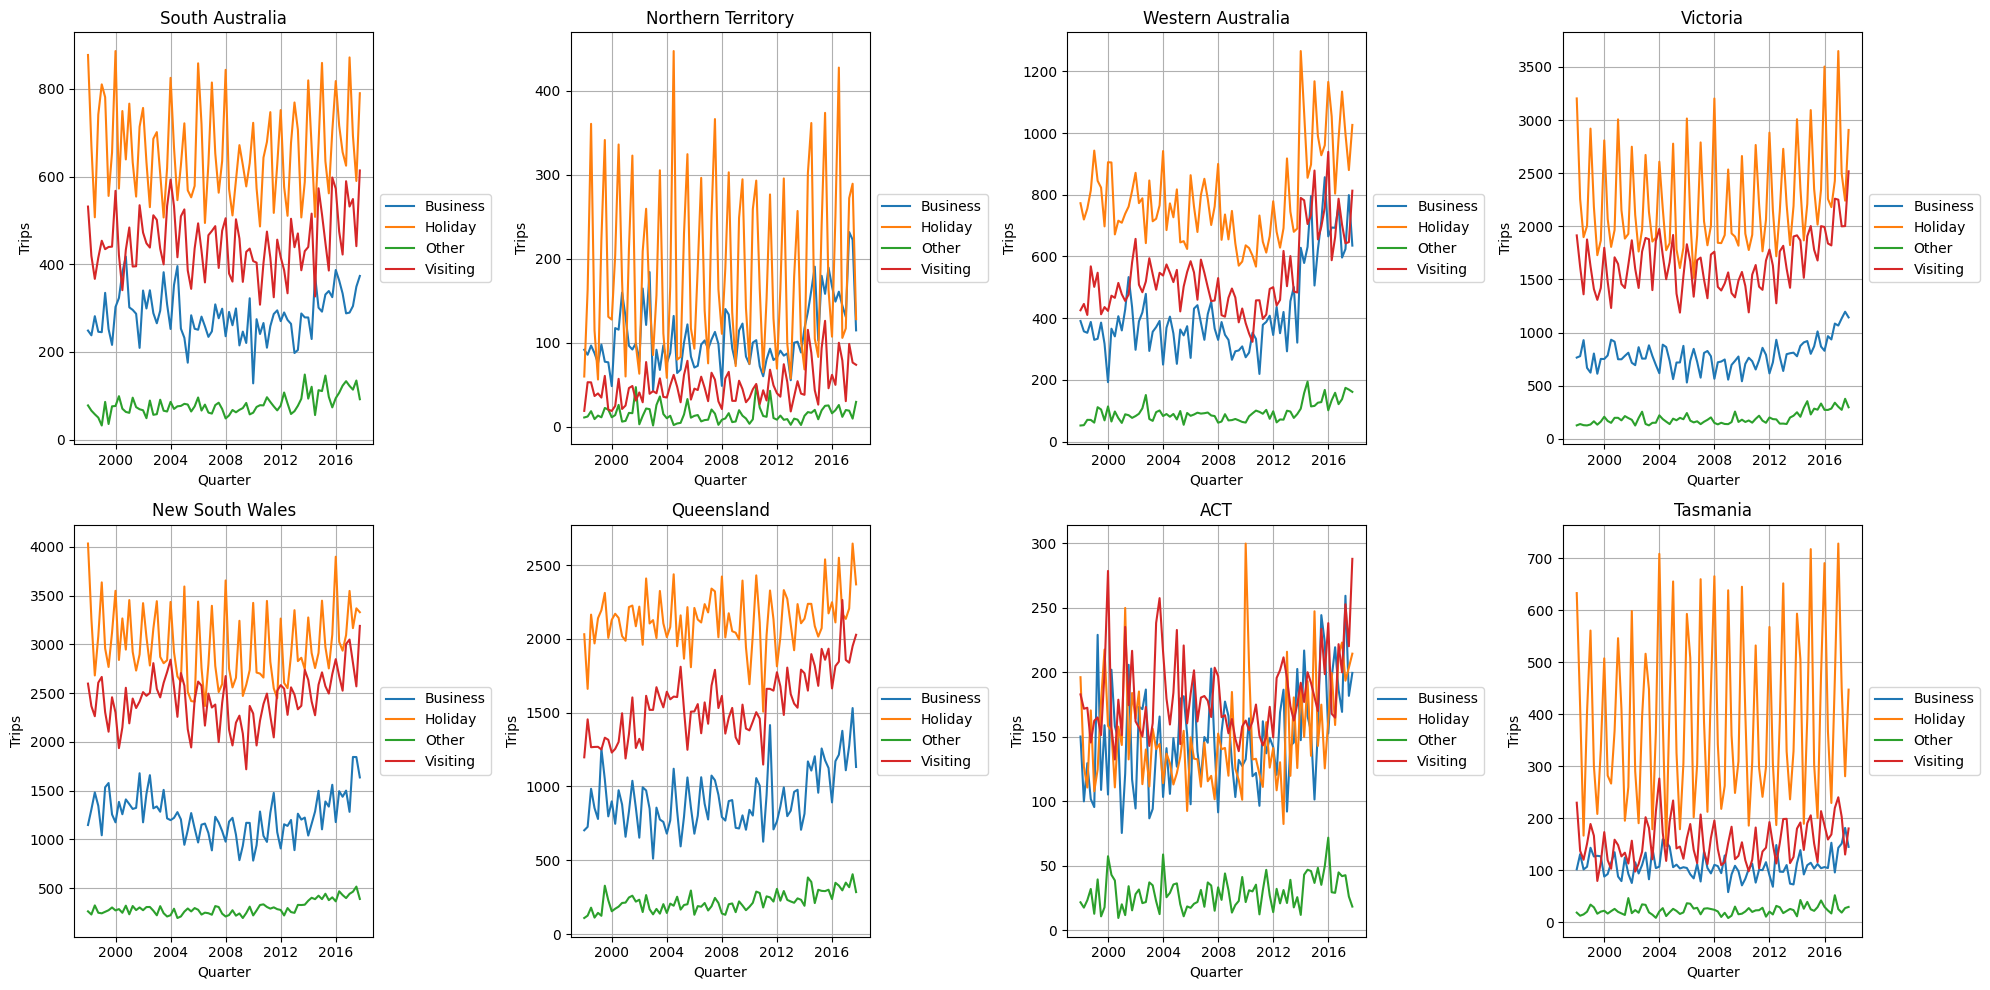

In [209]:
fig, ax = plt.subplots(2, 4, figsize=(20, 10))
ax = ax.flatten()

for axi, state in zip(ax, df.State.unique()):
    dfpp = dfp[dfp.State == state].reset_index(drop=True)
    sns.lineplot(dfpp, x="Quarter", y="Trips", hue="Purpose", ax=axi)
    axi.set_title(state)
    axi.grid(2)

    axi.legend(loc='center left', bbox_to_anchor=(1, .5));

plt.tight_layout()

### 2.0. Forecasting hierarchical approaches

Tradicionalmente as previsões em series hierárquicas se resume em selecionar uma série agregada e gerar as previsões para esta série, estas então são agregadas e desagregadas para os demais níveis da série para obter um conjunto de previsão coerente.

#### 2.1. The Bottom Up approach

Um simples método para gerar pervisões hierárquicas é utilizar o conceito de "baixo para cima", em resumo as previsões são feitas nos níveis mais baixos da série hierárquica e depois somadas para ir subindo nos níveis hierárquicos sem precisar desenvolver outros modelos para os outros níveis.
Por exemplo, considere o primeiro exemplo da série aninhada.

$\tilde{y}_{h} = \hat{y}_{AA,h} + \hat{y}_{AB,h} + \hat{y}_{AC,h} + \hat{y}_{BA,h} + \hat{y}_{BB,h}$

O $\tilde{y}_{h}$ representa as previsões coerentes de todas as previsões do nível mais baxio da série $\hat{y}_{..,h}$, consequentemente somando todas temos a previsão total. A vantagem dessa forma é que nenhuma informação é perdida quando é feita as agregações posteriores.

In [7]:
df = pd.read_csv("../data/tourism.csv", index_col=[0])
df['Quarter'] = df.Quarter.apply(lambda x: x.replace(' ', '-'))
df['Quarter'] = pd.PeriodIndex(df.Quarter, freq='Q').to_timestamp()

df = df[["Quarter", "State", "Trips"]].groupby(["Quarter", "State"]).sum().reset_index()

df.head()

Quarter               State        Trips
0 1998-01-01                 ACT   551.001921
1 1998-01-01     New South Wales  8039.794795
2 1998-01-01  Northern Territory   181.448823
3 1998-01-01          Queensland  4041.370159
4 1998-01-01     South Australia  1735.438418

Existe os modelos da biblioteca StatsForecast do Nixtla que já foram criados a fim de levar em conta um nível de agregação da série com a coluna unique_id.

No livro, seria algo bem mais simples, apenas seguiriamos o **"Workflow for forecasting aggregation structures"**:

`data |> aggregate_key() |> model() |> reconcile() |> forecast()`

O conceito de "reconciliation" nada mais é que a técnica de combinar as previsões de cada nível hierárquico que seja consistente com o restante dos níveis hierárquicos, por exemplo para somar as previsões hierárquicas e gerar as previsões para os proximos níveis.

In [10]:
df.columns = ["ds", "unique_id", "y"]

In [23]:
models = [
    AutoETS(
        season_length=4,
        alias="ets"
    )
]

sf = StatsForecast(
    models=models,
    freq="QS-JAN"
)

sf.fit(df)

forecast = sf.forecast(h=4 * 2, level=[90]).reset_index()

In [24]:
forecast.head()

unique_id         ds         ets   ets-lo-90   ets-hi-90
0       ACT 2018-01-01  707.237366  604.241394  810.233337
1       ACT 2018-04-01  723.997620  620.973145  827.022156
2       ACT 2018-07-01  740.757935  637.619751  843.896057
3       ACT 2018-10-01  757.518188  654.125183  860.911194
4       ACT 2019-01-01  774.278442  670.434265  878.122620

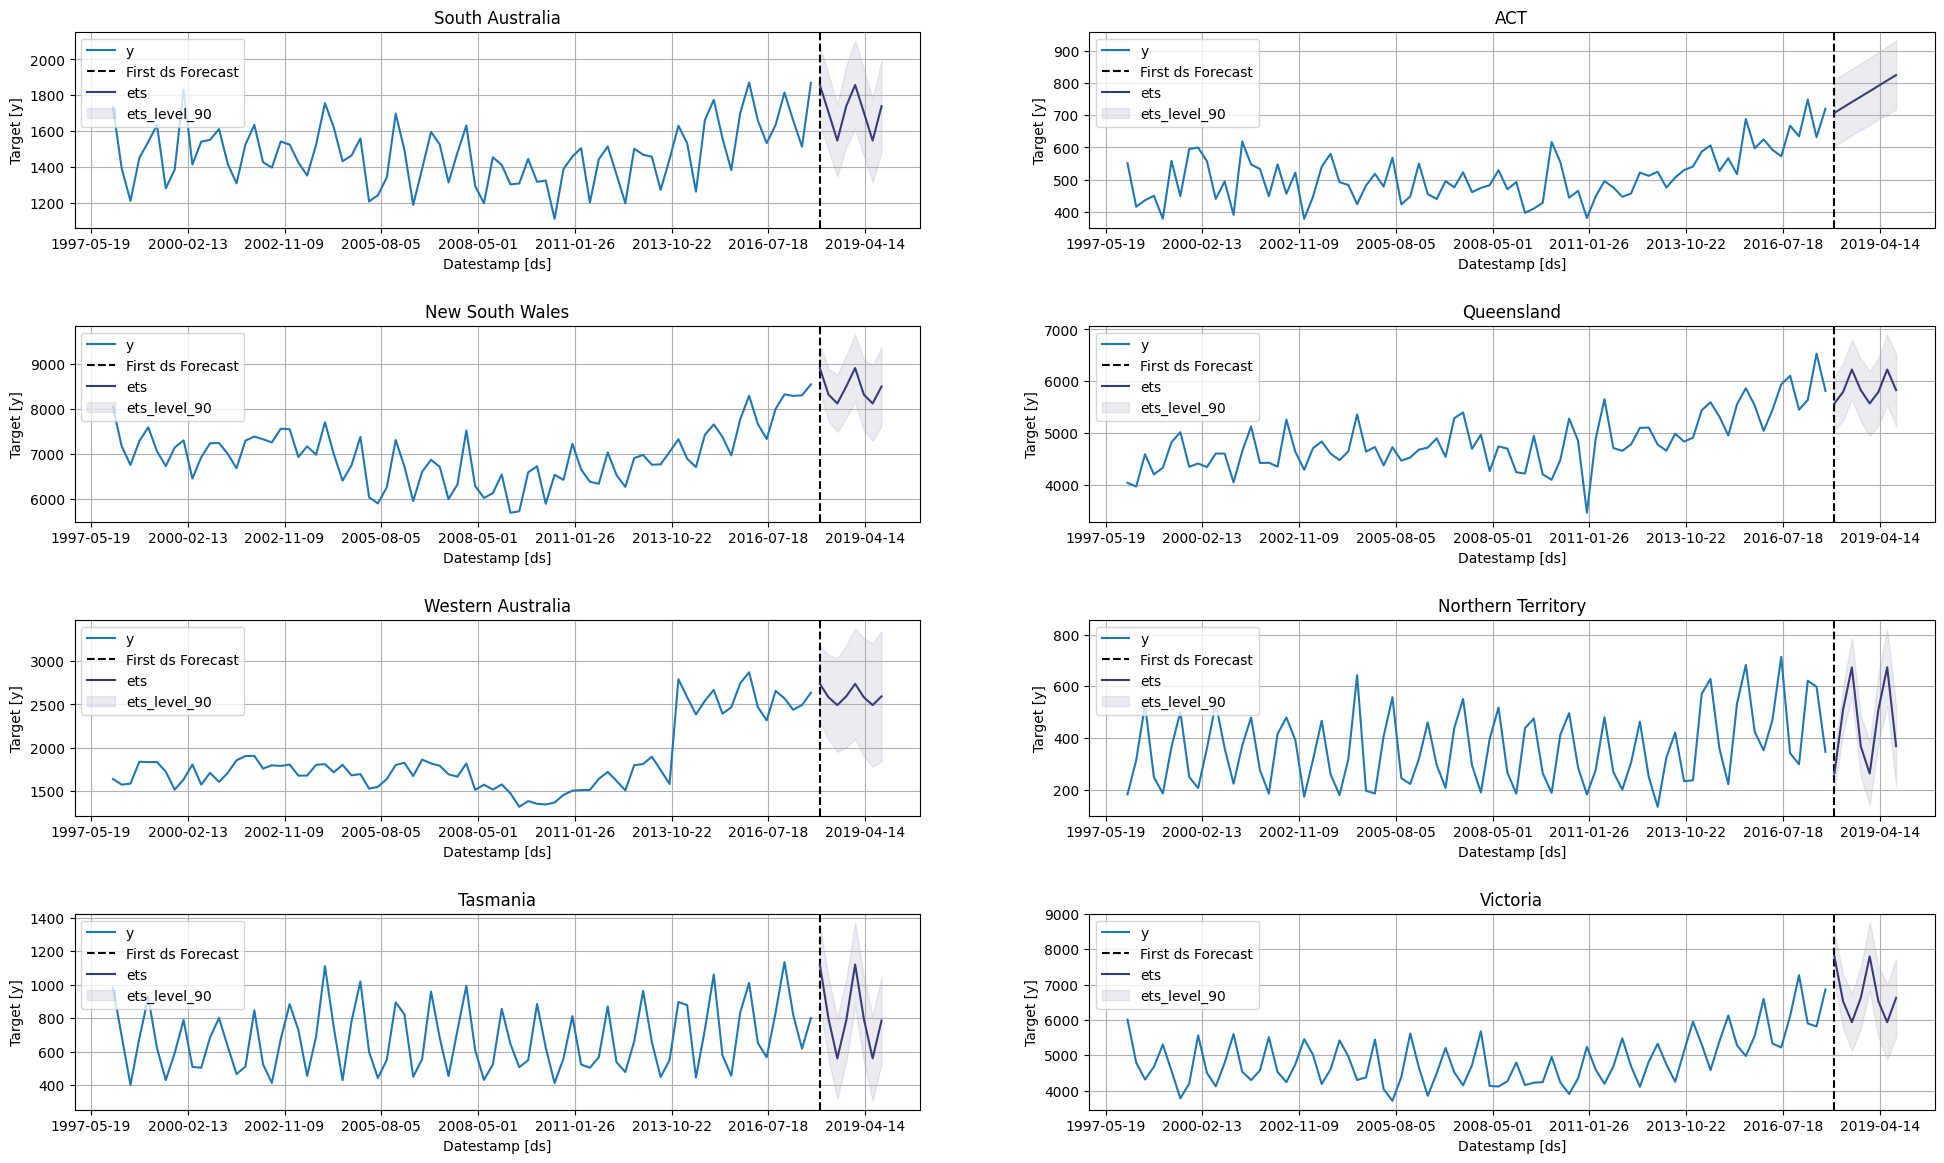

In [27]:
StatsForecast.plot(df, forecast)

Agora podemos somar e elevar a hierarquia da série para o total. Entretanto ainda temos que reconciliar no futuro com as técnicas de reconciliação que serão explicadas logo a frente no notebook.

In [34]:
df_total = df[["ds", "y"]].groupby("ds").sum().reset_index()
forecast_total = forecast[["ds", "ets", "ets-lo-90", "ets-hi-90"]].groupby("ds").sum().reset_index()

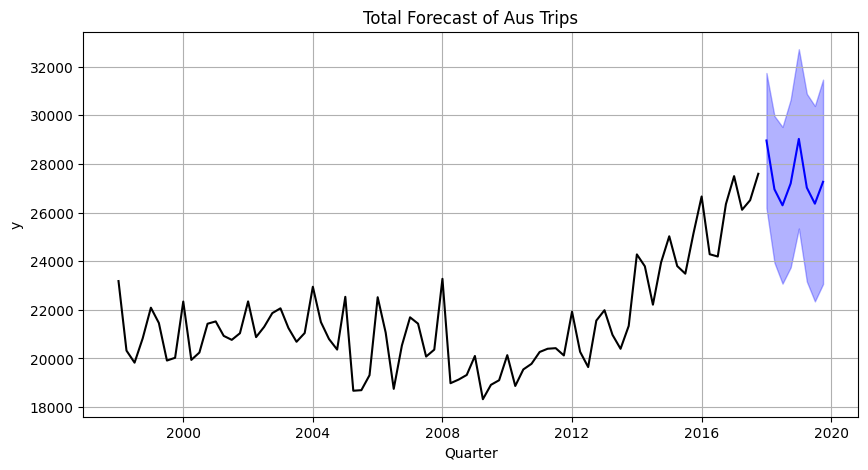

In [63]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(df_total.rename(columns={"ds": "Quarter"}), x="Quarter", y="y", ax=ax, color="k")
sns.lineplot(forecast_total.rename(columns={"ds": "Quarter"}), x="Quarter", y="ets", ax=ax, color="b")
ax.fill_between(forecast_total["ds"], forecast_total["ets-lo-90"], forecast_total["ets-hi-90"], color="b", alpha=0.3)
ax.grid(2)
ax.set_title("Total Forecast of Aus Trips");

#### 2.2. Top-down approaches & Middle-out approach

No livro é citado mais duas formas de gerar previsões hierárquicas, sendo elas o modelo top down onde inicia-se as previsçoes no topo para posteriormente serem desagregadas utilizando proporções de desagregação, é um pouco complexo isso então não irei dar sequencia nesse topico no notebook.

Já o approach Middle-out combina as duas técnicas anteriores mas possui algumas restrições.

#### 2.3. Forecasting Australian domestic tourism

Nós iremos calcular as previsões para o dataset de turismo novamente agora levando em conta mais hierarquias. Os dois ultimos anos são para teste e os demais para treino. 

Para levar em conta mais agregações da séries hierárquicas, é necessário outra bilbioteca chamada `hierarchicalforecast` e algumas outras preparações dos dados.

In [3]:
df = pd.read_csv("../data/tourism.csv", index_col=[0])
df['Quarter'] = df.Quarter.apply(lambda x: x.replace(' ', '-'))
df['Quarter'] = pd.PeriodIndex(df.Quarter, freq='Q').to_timestamp()

train = df[df.Quarter < "2016-01-01"].reset_index(drop=True)
test = df[df.Quarter >= "2016-01-01"].reset_index(drop=True)

train.rename(columns={"Quarter": "ds", "Trips": "y"}, inplace=True)
test.rename(columns={"Quarter": "ds", "Trips": "y"}, inplace=True)

In [4]:
train.head()

ds    Region            State   Purpose           y
0 1998-01-01  Adelaide  South Australia  Business  135.077690
1 1998-04-01  Adelaide  South Australia  Business  109.987316
2 1998-07-01  Adelaide  South Australia  Business  166.034687
3 1998-10-01  Adelaide  South Australia  Business  127.160464
4 1999-01-01  Adelaide  South Australia  Business  137.448533

A primeira preparação é a criação de uma matriz de mapeamento $S$ que indica quais são as séries e suas combinações para gerar uma reconciliação e mapear todas as combinações, onde o comprimento é $n * m$, isso irá indicar para a ferramenta as combinações.

Também geramos um novo conjunto de treino e teste que é o conjunto já preparado pelo `aggregate` da biblioteca e por fim as tags, que são o de -> para das agregações.

In [5]:
hierarchy = [
    ["State"],
    ["Purpose"],
    ["State", "Region"],
    ["State", "Region", "Purpose"]
]

train, df_s_agg, tags = aggregate(train, hierarchy)
test, _, _ = aggregate(test, hierarchy)

Obviamente, olhando por cima nesses dados, caso fosse necessário, teria que preprocessar eles, analisar para ver se existem estados com os nomes iguais mas com letras diferentes ou maísculas e minusculas, enfim, teria que pré processar e limpar os dados antes, nesse caso vou assumir que já estão todos limpos das análises previas, mas no mundo real teria que limpar.

In [6]:
train

ds           y
unique_id                                                         
ACT                                         1998-01-01  551.001921
ACT                                         1998-04-01  416.025623
ACT                                         1998-07-01  436.029011
ACT                                         1998-10-01  449.798445
ACT                                         1999-01-01  378.572817
...                                                ...         ...
Western Australia/Experience Perth/Visiting 2014-10-01  381.616236
Western Australia/Experience Perth/Visiting 2015-01-01  525.988913
Western Australia/Experience Perth/Visiting 2015-04-01  286.874141
Western Australia/Experience Perth/Visiting 2015-07-01  439.624378
Western Australia/Experience Perth/Visiting 2015-10-01  406.907362

[28224 rows x 2 columns]

In [7]:
df_s_agg.head()

ACT/Canberra/Business  ACT/Canberra/Holiday   
ACT                                   1.0                   1.0  \
New South Wales                       0.0                   0.0   
Northern Territory                    0.0                   0.0   
Queensland                            0.0                   0.0   
South Australia                       0.0                   0.0   

                    ACT/Canberra/Other  ACT/Canberra/Visiting   
ACT                                1.0                    1.0  \
New South Wales                    0.0                    0.0   
Northern Territory                 0.0                    0.0   
Queensland                         0.0                    0.0   
South Australia                    0.0                    0.0   

                    New South Wales/Blue Mountains/Business   
ACT                                                     0.0  \
New South Wales                                         1.0   
Northern Territory                                      0.0   
Queensland                                              0.0   
South Australia                                         0.0   

                    New South Wales/Blue Mountains/Holiday   
ACT                                                    0.0  \
New South Wales                                        1.0   
Northern Territory                                     0.0   
Queensland                                             0.0   
South Australia                                        0.0   

                    New South Wales/Blue Mountains/Other   
ACT                                                  0.0  \
New South Wales                                      1.0   
Northern Territory                                   0.0   
Queensland                                           0.0   
South Australia                                      0.0   

                    New South Wales/Blue Mountains/Visiting   
ACT                                                     0.0  \
New South Wales                                         1.0   
Northern Territory                                      0.0   
Queensland                                              0.0   
South Australia                                         0.0   

                    New South Wales/Capital Country/Business   
ACT                                                      0.0  \
New South Wales                                          1.0   
Northern Territory                                       0.0   
Queensland                                               0.0   
South Australia                                          0.0   

                    New South Wales/Capital Country/Holiday  ...   
ACT                                                     0.0  ...  \
New South Wales                                         1.0  ...   
Northern Territory                                      0.0  ...   
Queensland                                              0.0  ...   
South Australia                                         0.0  ...   

                    Western Australia/Australia's North West/Other   
ACT                                                            0.0  \
New South Wales                                                0.0   
Northern Territory                                             0.0   
Queensland                                                     0.0   
South Australia                                                0.0   

                    Western Australia/Australia's North West/Visiting   
ACT                                                               0.0  \
New South Wales                                                   0.0   
Northern Territory                                                0.0   
Queensland                                                        0.0   
South Australia                                                   0.0   

                    Western Australia/Australia's South West/Business   
ACT    

Agora, precisamos treinar o modelo, no livro foi selecionado um modelo ETS automático, então irei replicar oque tinha feito antes e treinar o mesmo modelo nos diversos níveis da série.

Precisamos obter os valores ajustados das séries para aplicar as técnicas de reconciliação.

In [8]:
models = [
    AutoETS(
        season_length=4,
        alias="ets"
    )
]

sf = StatsForecast(
    models=models,
    freq="QS-JAN"
)

sf.fit(train)

forecast = sf.forecast(h=4 * 2, level=[90], fitted=True)
fitted_values = sf.forecast_fitted_values()

Precisamos garantir que as previsões estão consistentes umas com as outras.
No livro é utilizado alguns métodos como o MinTrace, OLS e Bottom Up para as conciliações, mas existem outras.

Existe mais detalhes sobre isso neste post: https://forecastegy.com/posts/hierarchical-time-series-forecasting-python

Irei seguir as mesmas reconciliações do livro, que são:

```r
reconcile(
    bu = bottom_up(base),
    ols = min_trace(base, method = "ols"),
    mint = min_trace(base, method = "mint_shrink")
)
```

In [9]:
r = [
    BottomUp(), 
    MinTrace(method='ols', nonnegative=True),
    MinTrace(method='mint_shrink', nonnegative=True)
]

r_model = HierarchicalReconciliation(reconcilers=r)

In [ ]:
forecast_rec = r_model.reconcile(
    tags=tags,
    S=df_s_agg,
    Y_hat_df=forecast,
    Y_df=fitted_values,
)

In [11]:
forecast

ds         ets   
unique_id                                                            
ACT                                         2016-01-01  573.249207  \
ACT                                         2016-04-01  586.556458   
ACT                                         2016-07-01  599.863647   
ACT                                         2016-10-01  613.170898   
ACT                                         2017-01-01  626.478149   
...                                                ...         ...   
Western Australia/Experience Perth/Visiting 2016-10-01  414.555542   
Western Australia/Experience Perth/Visiting 2017-01-01  424.775116   
Western Australia/Experience Perth/Visiting 2017-04-01  401.802063   
Western Australia/Experience Perth/Visiting 2017-07-01  388.653900   
Western Australia/Experience Perth/Visiting 2017-10-01  414.555542   

                                              ets-lo-90   ets-hi-90  
unique_id                                                            
ACT                                          450.044800  696.453674  
ACT                                          460.450897  712.661987  
ACT                                          470.764465  728.962891  
ACT                                          480.935059  745.406738  
ACT                                          490.914886  762.041382  
...                                                 ...         ...  
Western Australia/Experience Perth/Visiting  276.109283  553.001831  
Western Australia/Experience Perth/Visiting  275.950439  573.599792  
Western Australia/Experience Perth/Visiting  249.298325  554.305786  
Western Australia/Experience Perth/Visiting  231.349854  545.957947  
Western Australia/Experience Perth/Visiting  246.137680  582.973450  

[3136 rows x 4 columns]

In [12]:
forecast_rec

ds         ets   
unique_id                                                            
ACT                                         2016-01-01  573.249207  \
ACT                                         2016-04-01  586.556458   
ACT                                         2016-07-01  599.863647   
ACT                                         2016-10-01  613.170898   
ACT                                         2017-01-01  626.478149   
...                                                ...         ...   
Western Australia/Experience Perth/Visiting 2016-10-01  414.555542   
Western Australia/Experience Perth/Visiting 2017-01-01  424.775116   
Western Australia/Experience Perth/Visiting 2017-04-01  401.802063   
Western Australia/Experience Perth/Visiting 2017-07-01  388.653900   
Western Australia/Experience Perth/Visiting 2017-10-01  414.555542   

                                              ets-lo-90   ets-hi-90   
unique_id                                                             
ACT                                          450.044800  696.453674  \
ACT                                          460.450897  712.661987   
ACT                                          470.764465  728.962891   
ACT                                          480.935059  745.406738   
ACT                                          490.914886  762.041382   
...                                                 ...         ...   
Western Australia/Experience Perth/Visiting  276.109283  553.001831   
Western Australia/Experience Perth/Visiting  275.950439  573.599792   
Western Australia/Experience Perth/Visiting  249.298325  554.305786   
Western Australia/Experience Perth/Visiting  231.349854  545.957947   
Western Australia/Experience Perth/Visiting  246.137680  582.973450   

                                             ets/BottomUp   
unique_id                                                   
ACT                                            510.536133  \
ACT                                            527.078979   
ACT                                            523.599426   
ACT                                            504.603027   
ACT                                            510.536133   
...                                                   ...   
Western Australia/Experience Perth/Visiting    414.555542   
Western Australia/Experience Perth/Visiting    424.775116   
Western Australia/Experience Perth/Visiting    401.802063   
Western Australia/Experience Perth/Visiting    388.653900   
Western Australia/Experience Perth/Visiting    414.555542   

                                             ets/MinTrace_method-ols_nonnegative-True   
unique_id                                                                               
ACT                                                                        577.741577  \
ACT                                                                        585.974976   
ACT                                                                        595.715332   
ACT                                                                        609.029175   
ACT                                                                        622.783569   
...                                                                               ...   
Western Australia/Experience Perth/Visiting                                424.014954   
Western Australia/Experience Perth/Visiting                                439.465759   
Western Australia/Experience Perth/Visiting                                407.553406   
Western Australia/Experience Perth/Visiting                                392.909363   
Western Australia/Experience Perth/Visiting                                423.844208   

                                             ets/MinTrace_method-mint_shrink_nonnegative-True  
unique_id                                                                                      
ACT                                                                      

Pronto, agora é so realizar as análises e ver as previsões no conjunto de teste.

In [13]:
forecast_rec = forecast_rec.reset_index()
test_plot = test.reset_index()
train_plot = train.reset_index()

##### 2.3.1. Total Level

In [14]:
train_total = train_plot[["ds", "y"]].groupby("ds").sum()
test_total = test_plot[["ds", "y"]].groupby("ds").sum()

f_plot = forecast_rec[["ds", "ets", "ets/BottomUp", "ets/MinTrace_method-ols_nonnegative-True", "ets/MinTrace_method-mint_shrink_nonnegative-True"]]
f_plot.columns = ["ds", "ets", "bu", "ols", "mint"]
forecast_total = f_plot.groupby("ds").sum()

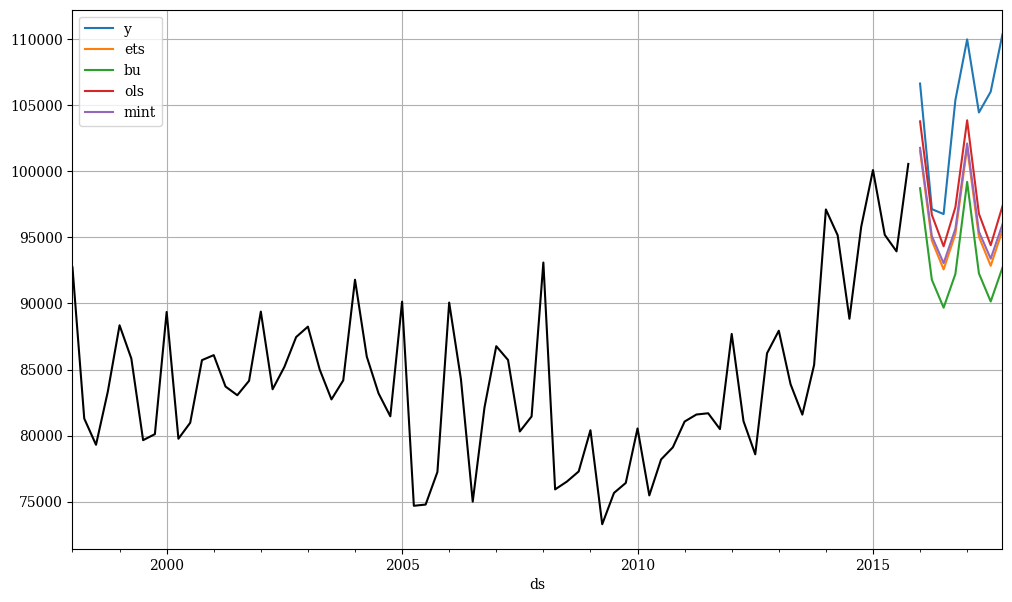

In [15]:
ax = train_total.plot(figsize=(12, 7), legend=None, color="k")
test_total.plot(ax=ax)
forecast_total.plot(ax=ax, grid=2);

In [16]:
tot_metrics = get_metrics(test_total, forecast_total, index_label="Total")

In [17]:
tot_metrics

metric         rmse                                                  mae   
model           ets            bu          ols         mint          ets   
Total   9359.160837  11953.962851  7752.246492  8990.903739  8422.566421  \

metric                                          
model             bu          ols         mint  
Total   11250.672866  6534.220718  8036.392593

##### 2.3.2. State Level

In [18]:
states = [
    'ACT',
    'New South Wales',
    'Northern Territory',
    'Queensland',
    'South Australia',
    'Tasmania',
    'Victoria',
    'Western Australia'
]

forecast_states = forecast_rec[forecast_rec.unique_id.isin(states)]

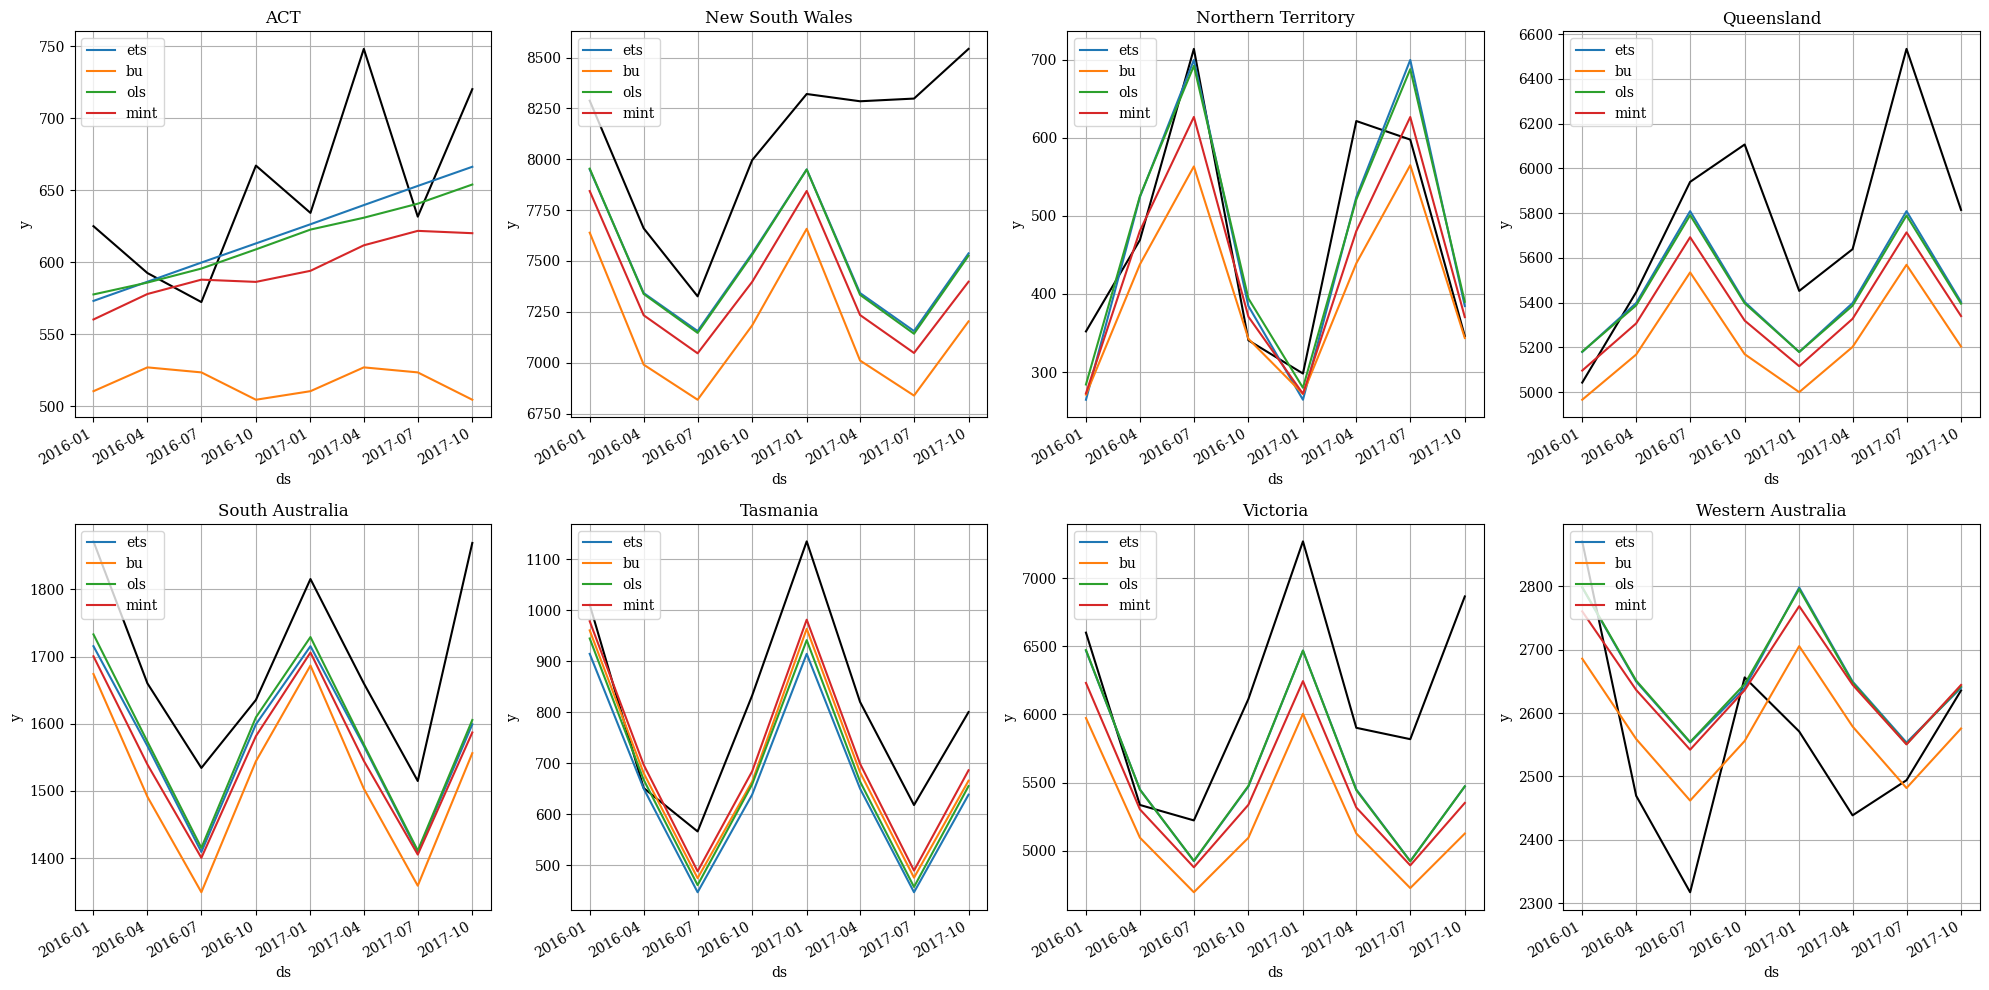

In [19]:
fig, ax = plt.subplots(2, 4, figsize=(20, 10))
ax = ax.flatten()

for axi, state in zip(ax, states):
    test_plt = test_plot[test_plot.unique_id == state].reset_index(drop=True)

    f_s_plt = forecast_states[forecast_states.unique_id == state].reset_index(drop=True)
    f_s_plt = f_s_plt[["ds", "ets", "ets/BottomUp", "ets/MinTrace_method-ols_nonnegative-True", "ets/MinTrace_method-mint_shrink_nonnegative-True"]]
    f_s_plt.columns = ["ds", "ets", "bu", "ols", "mint"]

    sns.lineplot(test_plt, x="ds", y="y", ax=axi, color="k")
    f_s_plt.plot(x="ds", ax=axi)

    axi.legend(loc="upper left")
    axi.set_title(state)
    axi.grid(2)

plt.tight_layout()

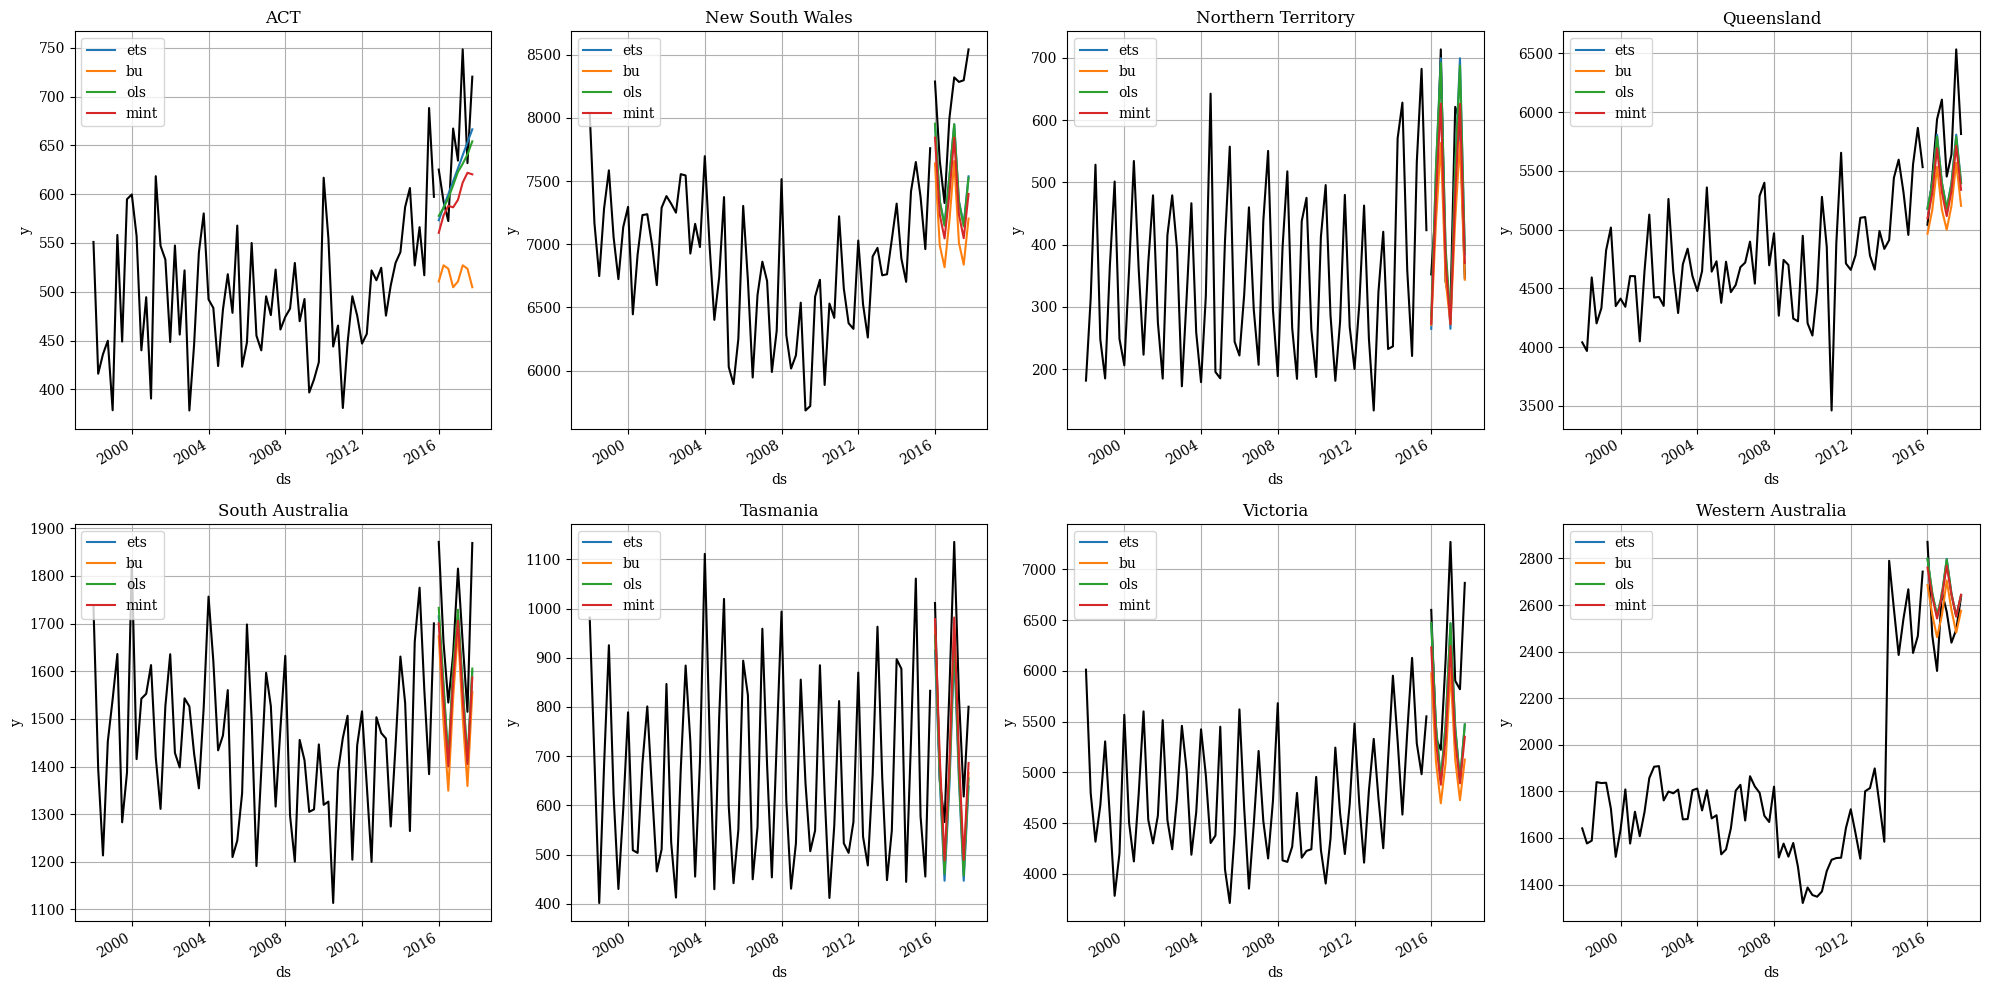

In [32]:
fig, ax = plt.subplots(2, 4, figsize=(20, 10))
ax = ax.flatten()

m = []
for axi, state in zip(ax, states):
    test_plt = test_plot[test_plot.unique_id == state].reset_index(drop=True)
    train_plt = train_plot[train_plot.unique_id == state].reset_index(drop=True)

    f_s_plt = forecast_states[forecast_states.unique_id == state].reset_index(drop=True)
    f_s_plt = f_s_plt[["ds", "ets", "ets/BottomUp", "ets/MinTrace_method-ols_nonnegative-True", "ets/MinTrace_method-mint_shrink_nonnegative-True"]]
    f_s_plt.columns = ["ds", "ets", "bu", "ols", "mint"]

    m.append(get_metrics(test_plt, f_s_plt, index_label=state))

    sns.lineplot(train_plt, x="ds", y="y", ax=axi, color="k")
    sns.lineplot(test_plt, x="ds", y="y", ax=axi, color="k")
    f_s_plt.plot(x="ds", ax=axi)

    axi.legend(loc="upper left")
    axi.set_title(state)
    axi.grid(2)

plt.tight_layout()

In [35]:
state_metrics = pd.concat(m)

state_metrics

metric                    rmse                                        
model                      ets           bu         ols        mint   
ACT                  51.963256   145.241866   55.423648   72.036966  \
New South Wales     688.772449   985.790815  696.081339  792.064513   
Northern Territory   66.404880    90.226860   62.845337   67.897019   
Queensland          412.536239   594.351747  420.907288  475.825139   
South Australia     138.146371   184.831707  131.027620  150.605828   
Tasmania            155.886641   126.079044  139.142072  111.378609   
Victoria            717.918889  1011.829758  717.718347  822.052140   
Western Australia   155.694511   119.911397  155.098658  148.422663   

metric                     mae                                      
model                      ets          bu         ols        mint  
ACT                  41.384029  132.564336   42.451114   57.783325  
New South Wales     593.138306  921.822998  599.525025  708.868347  
Northern Territory   58.984221   63.492079   56.525179   53.561797  
Queensland          333.897135  520.360866  343.225199  396.338114  
South Australia     122.410650  174.574988  114.264563  136.965948  
Tasmania            141.851181  115.830423  127.206746  102.833463  
Victoria            591.183870  910.770479  590.378084  696.717867  
Western Australia   126.060638  108.457047  125.005004  124.042998

In [38]:
state_metrics.sum(axis=0)

metric  model
rmse    ets      2387.323236
        bu       3258.263194
        ols      2378.244310
        mint     2640.282877
mae     ets      2008.910030
        bu       2947.873215
        ols      1998.580915
        mint     2277.111860
dtype: float64

##### 2.3.3. Purpose Level

In [39]:
p_list = [
    'Business',
    'Holiday',
    'Other',
    'Visiting',
]

forecast_p = forecast_rec[forecast_rec.unique_id.isin(p_list)]

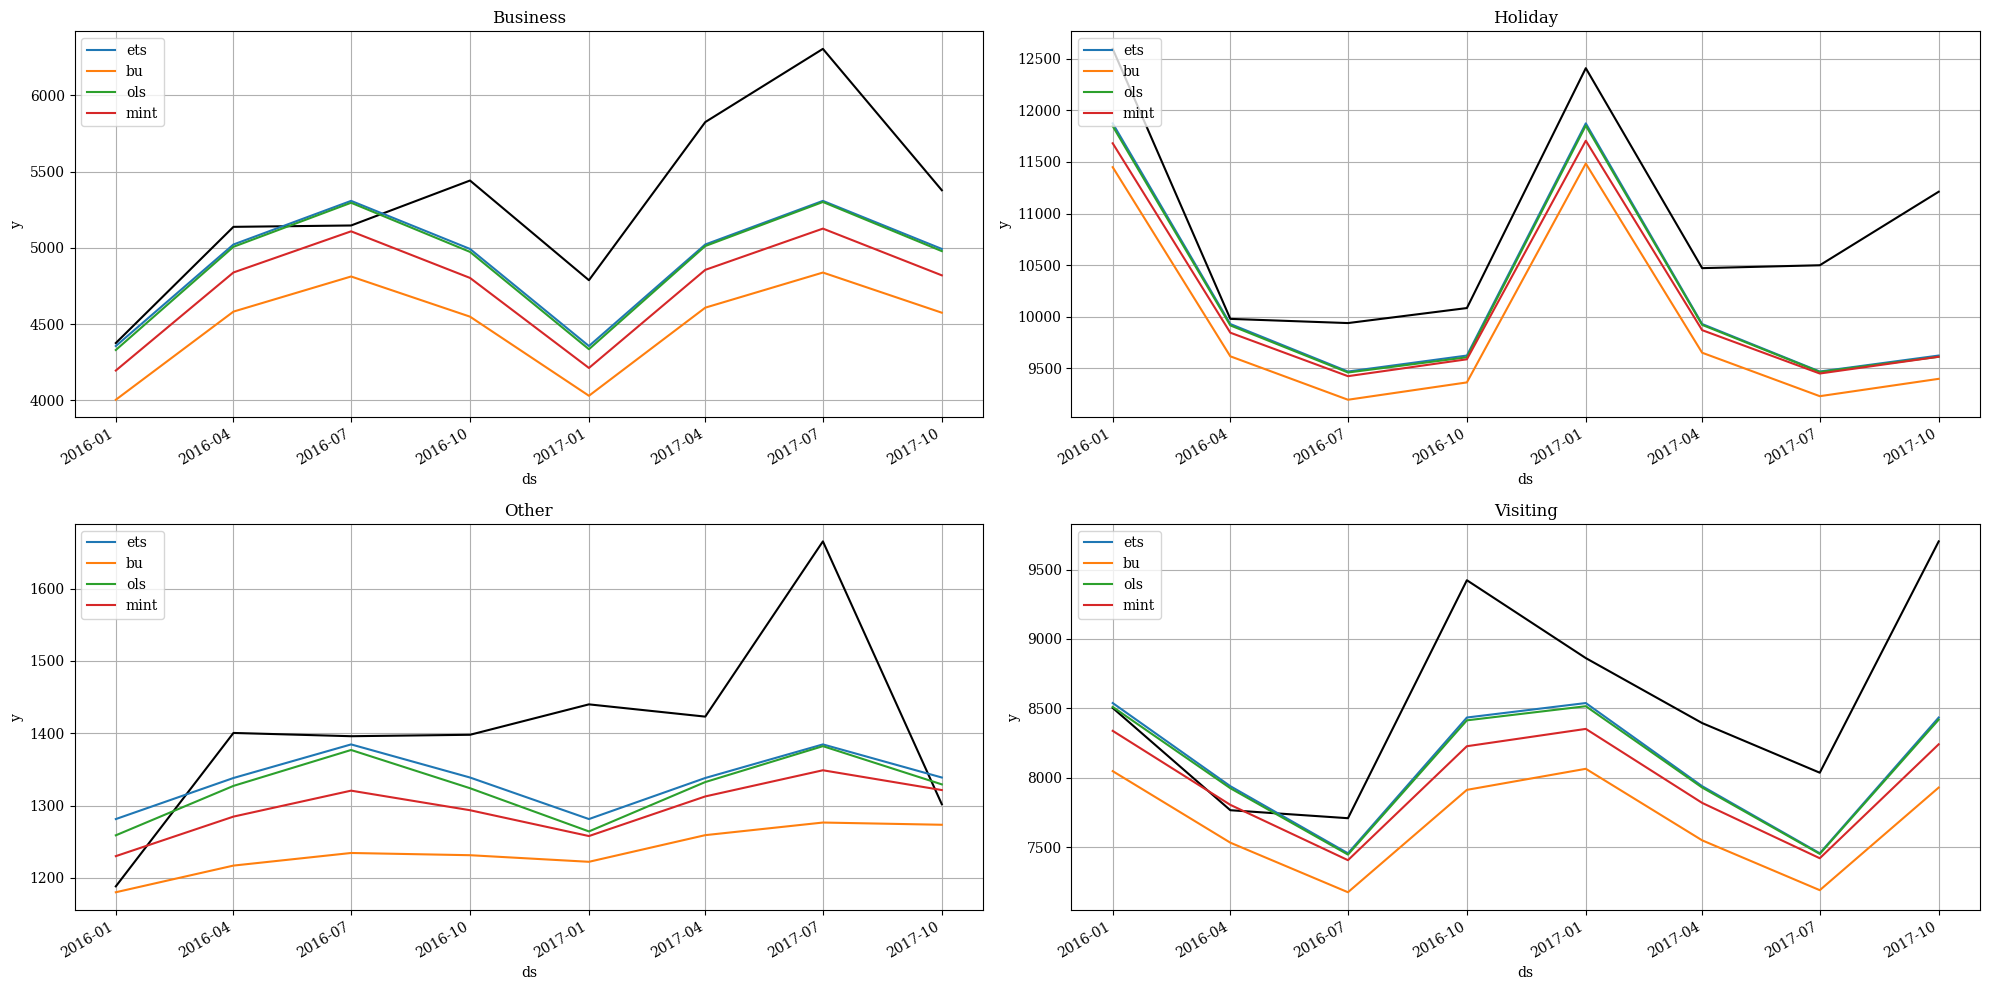

In [44]:
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
ax = ax.flatten()

m = []
for axi, p in zip(ax, p_list):
    test_plt = test_plot[test_plot.unique_id == p].reset_index(drop=True)

    f_s_plt = forecast_p[forecast_p.unique_id == p].reset_index(drop=True)
    f_s_plt = f_s_plt[["ds", "ets", "ets/BottomUp", "ets/MinTrace_method-ols_nonnegative-True", "ets/MinTrace_method-mint_shrink_nonnegative-True"]]
    f_s_plt.columns = ["ds", "ets", "bu", "ols", "mint"]

    sns.lineplot(test_plt, x="ds", y="y", ax=axi, color="k")
    f_s_plt.plot(x="ds", ax=axi)

    m.append(get_metrics(test_plt, f_s_plt, index_label=p))

    axi.legend(loc="upper left")
    axi.set_title(p)
    axi.grid(2)

plt.tight_layout()

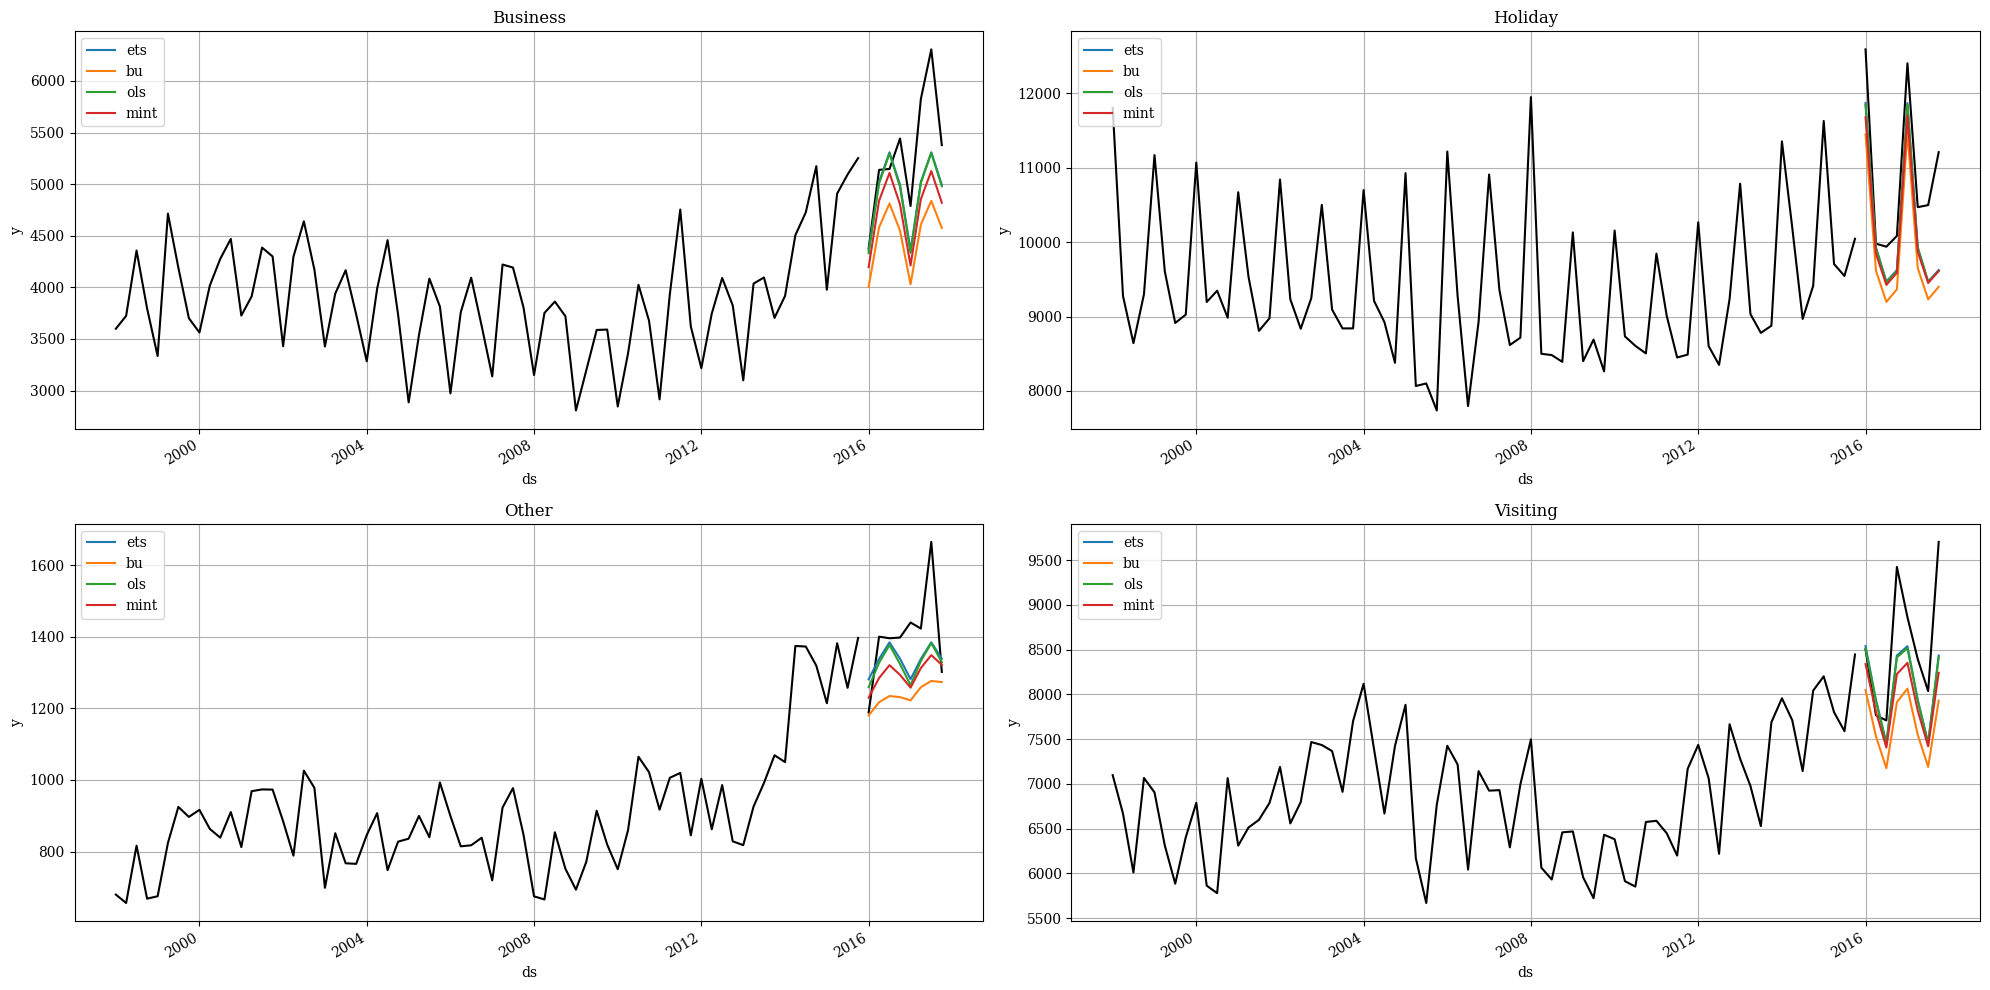

In [46]:
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
ax = ax.flatten()

m = []
for axi, p in zip(ax, p_list):
    train_plt = train_plot[train_plot.unique_id == p].reset_index(drop=True)
    test_plt = test_plot[test_plot.unique_id == p].reset_index(drop=True)

    f_s_plt = forecast_p[forecast_p.unique_id == p].reset_index(drop=True)
    f_s_plt = f_s_plt[["ds", "ets", "ets/BottomUp", "ets/MinTrace_method-ols_nonnegative-True", "ets/MinTrace_method-mint_shrink_nonnegative-True"]]
    f_s_plt.columns = ["ds", "ets", "bu", "ols", "mint"]

    sns.lineplot(train_plt, x="ds", y="y", ax=axi, color="k")
    sns.lineplot(test_plt, x="ds", y="y", ax=axi, color="k")
    f_s_plt.plot(x="ds", ax=axi)

    m.append(get_metrics(test_plt, f_s_plt, index_label=p))

    axi.legend(loc="upper left")
    axi.set_title(p)
    axi.grid(2)

plt.tight_layout()

In [49]:
p_metrics = pd.concat(m)
p_metrics

metric          rmse                                              mae   
model            ets           bu         ols        mint         ets   
Business  526.200368   881.168271  535.601743  661.867595  420.334465  \
Holiday   798.592738  1055.744535  809.853268  856.158894  673.457498   
Other     126.788542   197.952318  130.413037  148.926438   98.332360   
Visiting  645.256062  1002.235878  655.675089  762.888756  509.627036   

metric                                        
model             bu         ols        mint  
Business  800.190777  432.918510  554.887890  
Holiday   973.531228  687.568704  750.524270  
Other     164.722337  101.657617  120.655709  
Visiting  874.223340  514.628196  608.023345

In [51]:
p_metrics.sum()

metric  model
rmse    ets      2096.837711
        bu       3137.101001
        ols      2131.543137
        mint     2429.841684
mae     ets      1701.751359
        bu       2812.667682
        ols      1736.773027
        mint     2034.091215
dtype: float64

##### 2.3.4. Region Level Level

In [81]:
forecast_rec[forecast_rec.unique_id.str.contains("ACT")].unique_id.unique().tolist()

['ACT',
 'ACT/Canberra',
 'ACT/Canberra/Business',
 'ACT/Canberra/Holiday',
 'ACT/Canberra/Other',
 'ACT/Canberra/Visiting']

In [82]:
df_regions = pd.DataFrame()

for s in states:
    dff = forecast_rec[forecast_rec.unique_id.str.contains(f"^{s}/[a-zA-Z]+$", regex=True)]

    df_regions = pd.concat([df_regions, dff], axis=0)

df_regions.reset_index(drop=True, inplace=True)
df_regions.columns = ["unique_id", "ds", "ets", "lower", "upper", "bu", "ols", "mint"]

In [107]:
region_m = []
for region in df_regions.unique_id.unique():
    dfr = df_regions[df_regions.unique_id == region].reset_index(drop=True)
    dft = test_plot[test_plot.unique_id == region].reset_index(drop=True)

    region_m.append(get_metrics(dft, dfr, region))

region_metrics = pd.concat(region_m)

In [108]:
region_metrics.sort_values(by=("rmse", "bu"))

metric                               rmse                                       
model                                 ets          bu         ols        mint   
Northern Territory/MacDonnell   11.115516   10.861549    8.906452   10.460773  \
South Australia/Barossa         10.810807   11.272973   11.518773   10.805033   
Northern Territory/Barkly       12.513906   12.391480   11.465663   11.757083   
South Australia/Murraylands     16.333906   16.205265   15.995920   16.033764   
Northern Territory/Lasseter     14.712058   17.063378   14.834703   14.500063   
Victoria/Wimmera                20.687983   18.459275   16.474720   18.290204   
Northern Territory/Darwin       23.412904   20.298644   23.909182   22.109456   
South Australia/Riverland       23.649167   23.991351   21.149462   22.335356   
Queensland/Whitsundays          25.612500   25.445559   30.199419   25.387028   
Queensland/Bundaberg            24.908936   27.721750   24.369351   25.059947   
New South Wales/Riverina        29.842830   29.414690   35.981833   29.936495   
Victoria/Macedon                17.386844   30.454286   19.865831   17.580613   
Victoria/Lakes                  35.953017   34.425959   27.513594   32.254310   
Queensland/Outback              46.100208   37.094935   30.835991   37.982001   
Victoria/Mallee                 31.306885   37.243085   27.293734   30.348026   
Queensland/Northern             55.224908   37.533163   38.502498   36.822101   
Queensland/Mackay               34.385551   38.659536   25.862026   31.682704   
Victoria/Goulburn               42.429581   45.439503   35.950590   39.971286   
Victoria/Ballarat               46.876839   47.427325   40.314675   42.813815   
Victoria/Peninsula              59.394976   67.996819   55.629722   58.051670   
South Australia/Adelaide        81.449153   77.381687   75.658499   66.100504   
Victoria/Gippsland              89.580454   89.133105   81.472006   84.124315   
ACT/Canberra                    51.963256  145.241866   55.423648   72.036966   
New South Wales/Hunter         146.818732  175.526629  139.741134  148.821429   
Queensland/Brisbane            234.956714  219.360691  216.790098  193.214742   
New South Wales/Sydney         273.194854  253.849805  254.257688  227.968834   
Victoria/Melbourne             274.885481  290.814141  270.449556  258.693488   

metric                                mae                                      
model                                 ets          bu         ols        mint  
Northern Territory/MacDonnell    9.890158    9.488534    7.041148    9.286173  
South Australia/Barossa          7.918195    7.588205    9.587773    7.678279  
Northern Territory/Barkly        9.671869    9.252395    9.897907    9.249874  
South Australia/Murraylands     13.707051   13.707051   14.420597   13.703144  
Northern Territory/Lasseter     11.620438   14.134824   12.932012   11.612468  
Victoria/Wimmera                16.411314   15.009975   12.546471   15.154882  
Northern Territory/Darwin       18.681424   13.707546   20.107755   18.832881  
South Australia/Riverland       15.910835   16.412817   14.319072   14.952999  
Queensland/Whitsundays          23.482627   23.288274   24.141841   23.443644  
Queensland/Bundaberg            20.720815   22.647619   20.898738   21.191740  
New South Wales/Riverina        28.623504   27.378921   29.580115   27.880521  
Victoria/Macedon                14.389614   26.424926   17.286680   14.068726  
Victoria/Lakes                  32.346856   31.210433   25.582370   29.645520  
Queensland/Outback              39.919251   30.644406   24.061239   31.353123  
Victoria/Mallee                 25.791200   31.580742   22.437341   25.239469  
Queensland/Northern             49.633457   29.938942   31.963215   29.211548  
Queensland/Mackay               26.458593   29.390449   16.782405   22.745651  
Victoria/Goulburn               36.552597   38.696200   29.038235   33.693535  
Victoria/Ballarat               40.286124   40.996

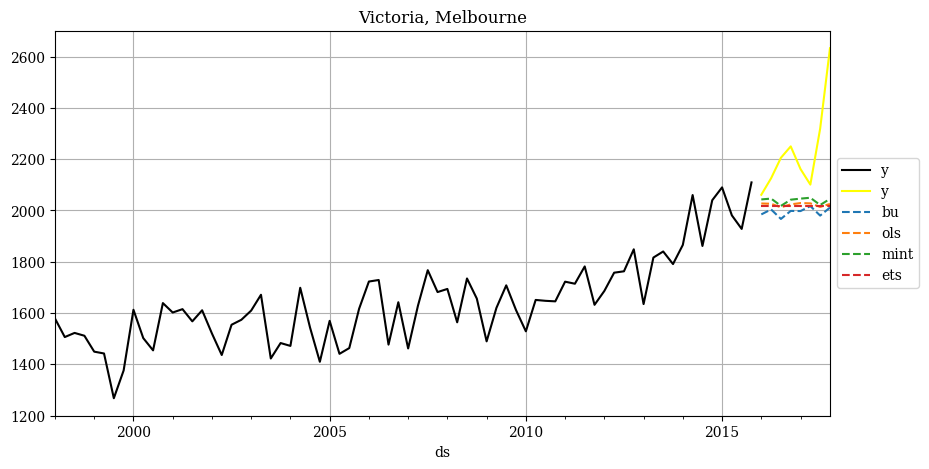

In [133]:
dfr = df_regions[df_regions.unique_id == "Victoria/Melbourne"].reset_index(drop=True)
dft = test_plot[test_plot.unique_id == "Victoria/Melbourne"].reset_index(drop=True)
dfx = train_plot[train_plot.unique_id == "Victoria/Melbourne"].reset_index(drop=True)

ax = dfx.plot(x="ds", y="y", figsize=(10, 5), color="k", legend=None)
dft.plot(x="ds", ax=ax, color="yellow", legend=None)
dfr[["ds", "bu", "ols", "mint", "ets"]].plot(x="ds", ax=ax, grid=2, linestyle="--")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set_title("Victoria, Melbourne");

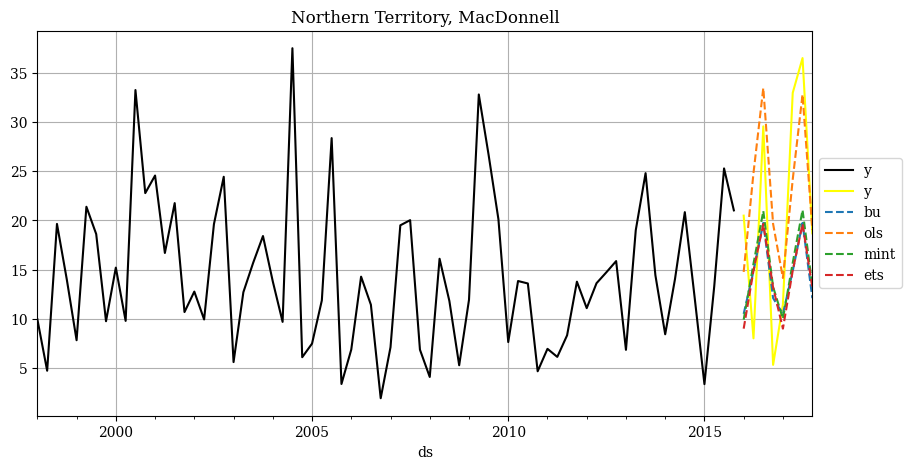

In [132]:
dfr = df_regions[df_regions.unique_id == "Northern Territory/MacDonnell"].reset_index(drop=True)
dft = test_plot[test_plot.unique_id == "Northern Territory/MacDonnell"].reset_index(drop=True)
dfx = train_plot[train_plot.unique_id == "Northern Territory/MacDonnell"].reset_index(drop=True)

ax = dfx.plot(x="ds", y="y", figsize=(10, 5), color="k", legend=None)
dft.plot(x="ds", ax=ax, color="yellow", legend=None)
dfr[["ds", "bu", "ols", "mint", "ets"]].plot(x="ds", ax=ax, grid=2, linestyle="--")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set_title("Northern Territory, MacDonnell");

##### 2.3.5. Overview

In [53]:
tot_metrics

metric         rmse                                                  mae   
model           ets            bu          ols         mint          ets   
Total   9359.160837  11953.962851  7752.246492  8990.903739  8422.566421  \

metric                                          
model             bu          ols         mint  
Total   11250.672866  6534.220718  8036.392593

In [52]:
p_metrics

metric          rmse                                              mae   
model            ets           bu         ols        mint         ets   
Business  526.200368   881.168271  535.601743  661.867595  420.334465  \
Holiday   798.592738  1055.744535  809.853268  856.158894  673.457498   
Other     126.788542   197.952318  130.413037  148.926438   98.332360   
Visiting  645.256062  1002.235878  655.675089  762.888756  509.627036   

metric                                        
model             bu         ols        mint  
Business  800.190777  432.918510  554.887890  
Holiday   973.531228  687.568704  750.524270  
Other     164.722337  101.657617  120.655709  
Visiting  874.223340  514.628196  608.023345

In [54]:
state_metrics

metric                    rmse                                        
model                      ets           bu         ols        mint   
ACT                  51.963256   145.241866   55.423648   72.036966  \
New South Wales     688.772449   985.790815  696.081339  792.064513   
Northern Territory   66.404880    90.226860   62.845337   67.897019   
Queensland          412.536239   594.351747  420.907288  475.825139   
South Australia     138.146371   184.831707  131.027620  150.605828   
Tasmania            155.886641   126.079044  139.142072  111.378609   
Victoria            717.918889  1011.829758  717.718347  822.052140   
Western Australia   155.694511   119.911397  155.098658  148.422663   

metric                     mae                                      
model                      ets          bu         ols        mint  
ACT                  41.384029  132.564336   42.451114   57.783325  
New South Wales     593.138306  921.822998  599.525025  708.868347  
Northern Territory   58.984221   63.492079   56.525179   53.561797  
Queensland          333.897135  520.360866  343.225199  396.338114  
South Australia     122.410650  174.574988  114.264563  136.965948  
Tasmania            141.851181  115.830423  127.206746  102.833463  
Victoria            591.183870  910.770479  590.378084  696.717867  
Western Australia   126.060638  108.457047  125.005004  124.042998

In [134]:
region_metrics

metric                               rmse                                       
model                                 ets          bu         ols        mint   
ACT/Canberra                    51.963256  145.241866   55.423648   72.036966  \
New South Wales/Hunter         146.818732  175.526629  139.741134  148.821429   
New South Wales/Riverina        29.842830   29.414690   35.981833   29.936495   
New South Wales/Sydney         273.194854  253.849805  254.257688  227.968834   
Northern Territory/Barkly       12.513906   12.391480   11.465663   11.757083   
Northern Territory/Darwin       23.412904   20.298644   23.909182   22.109456   
Northern Territory/Lasseter     14.712058   17.063378   14.834703   14.500063   
Northern Territory/MacDonnell   11.115516   10.861549    8.906452   10.460773   
Queensland/Brisbane            234.956714  219.360691  216.790098  193.214742   
Queensland/Bundaberg            24.908936   27.721750   24.369351   25.059947   
Queensland/Mackay               34.385551   38.659536   25.862026   31.682704   
Queensland/Northern             55.224908   37.533163   38.502498   36.822101   
Queensland/Outback              46.100208   37.094935   30.835991   37.982001   
Queensland/Whitsundays          25.612500   25.445559   30.199419   25.387028   
South Australia/Adelaide        81.449153   77.381687   75.658499   66.100504   
South Australia/Barossa         10.810807   11.272973   11.518773   10.805033   
South Australia/Murraylands     16.333906   16.205265   15.995920   16.033764   
South Australia/Riverland       23.649167   23.991351   21.149462   22.335356   
Victoria/Ballarat               46.876839   47.427325   40.314675   42.813815   
Victoria/Gippsland              89.580454   89.133105   81.472006   84.124315   
Victoria/Goulburn               42.429581   45.439503   35.950590   39.971286   
Victoria/Lakes                  35.953017   34.425959   27.513594   32.254310   
Victoria/Macedon                17.386844   30.454286   19.865831   17.580613   
Victoria/Mallee                 31.306885   37.243085   27.293734   30.348026   
Victoria/Melbourne             274.885481  290.814141  270.449556  258.693488   
Victoria/Peninsula              59.394976   67.996819   55.629722   58.051670   
Victoria/Wimmera                20.687983   18.459275   16.474720   18.290204   

metric                                mae                                      
model                                 ets          bu         ols        mint  
ACT/Canberra                    41.384029  132.564336   42.451114   57.783325  
New South Wales/Hunter         126.876453  153.128696  119.929722  128.308788  
New South Wales/Riverina        28.623504   27.378921   29.580115   27.880521  
New South Wales/Sydney         247.152596  229.576882  227.186685  198.564218  
Northern Territory/Barkly        9.671869    9.252395    9.897907    9.249874  
Northern Territory/Darwin       18.681424   13.707546   20.107755   18.832881  
Northern Territory/Lasseter     11.620438   14.134824   12.932012   11.612468  
Northern Territory/MacDonnell    9.890158    9.488534    7.041148    9.286173  
Queensland/Brisbane            198.178390  176.928207  180.265518  155.359161  
Queensland/Bundaberg            20.720815   22.647619   20.898738   21.191740  
Queensland/Mackay               26.458593   29.390449   16.782405   22.745651  
Queensland/Northern             49.633457   29.938942   31.963215   29.211548  
Queensland/Outback              39.919251   30.644406   24.061239   31.353123  
Queensland/Whitsundays          23.482627   23.288274   24.141841   23.443644  
South Australia/Adelaide        75.730594   73.067112   70.373546   60.721233  
South Australia/Barossa          7.918195    7.588205    9.587773    7.678279  
South Australia/Murraylands     13.707051   13.707051   14.420597   13.703144  
South Australia/Riverland       15.910835   16.412817   14.319072   14.952999  
Victoria/Ballarat               40.286124   40.996